In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

In [2]:
# df = pd.read_csv("../../en.openfoodfacts.org.products.tsv", delimiter='\t', encoding='utf-8')

df = pd.read_csv("en.openfoodfacts.org.products.tsv", delimiter='\t', encoding='utf-8')

/opt/apps/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [48]:
df.shape

(356027, 163)

In [7]:
pd.set_option('display.max_rows', len(df))
pd.set_option('display.max_columns', 163)
df.head(50)

code                                                url  \
0    3087  http://world-en.openfoodfacts.org/product/0000...   
1    4530  http://world-en.openfoodfacts.org/product/0000...   
2    4559  http://world-en.openfoodfacts.org/product/0000...   
3   16087  http://world-en.openfoodfacts.org/product/0000...   
4   16094  http://world-en.openfoodfacts.org/product/0000...   
5   16100  http://world-en.openfoodfacts.org/product/0000...   
6   16117  http://world-en.openfoodfacts.org/product/0000...   
7   16124  http://world-en.openfoodfacts.org/product/0000...   
8   16193  http://world-en.openfoodfacts.org/product/0000...   
9   16513  http://world-en.openfoodfacts.org/product/0000...   
10  16612  http://world-en.openfoodfacts.org/product/0000...   
11  16650  http://world-en.openfoodfacts.org/product/0000...   
12  16872  http://world-en.openfoodfacts.org/product/0000...   
13  16933  http://world-en.openfoodfacts.org/product/0000...   
14  17497  http://world-en.openfoodfacts.org/product/0000...   
15  18012  http://world-en.openfoodfacts.org/product/0000...   
16  18050  http://world-en.openfoodfacts.org/product/0000...   
17  18173  http://world-en.openfoodfacts.org/product/0000...   
18  18197  http://world-en.openfoodfacts.org/product/0000...   
19  18227  http://world-en.openfoodfacts.org/product/0000...   
20  18265  http://world-en.openfoodfacts.org/product/0000...   
21  18289  http://world-en.openfoodfacts.org/product/0000...   
22  18319  http://world-en.openfoodfacts.org/product/0000...   
23  18340  http://world-en.openfoodfacts.org/product/0000...   
24  18357  http://world-en.openfoodfacts.org/product/0000...   
25  18371  http://world-en.openfoodfacts.org/product/0000...   
26  18388  http://world-en.openfoodfacts.org/product/0000...   
27  18395  http://world-en.openfoodfacts.org/product/0000...   
28  18401  http://world-en.openfoodfacts.org/product/0000...   
29  18418  http://world-en.openfoodfacts.org/product/0000...   
30  18449  http://world-en.openfoodfacts.org/product/0000...   
31  18456  http://world-en.openfoodfacts.org/product/0000...   
32  18500  http://world-en.openfoodfacts.org/product/0000...   
33  18517  http://world-en.openfoodfacts.org/product/0000...   
34  18524  http://world-en.openfoodfacts.org/product/0000...   
35  18555  http://world-en.openfoodfacts.org/product/0000...   
36  18562  http://world-en.openfoodfacts.org/product/0000...   
37  18579  http://world-en.openfoodfacts.org/product/0000...   
38  18630  http://world-en.openfoodfacts.org/product/0000...   
39  18708  http://world-en.openfoodfacts.org/product/0000...   
40  18753  http://world-en.openfoodfacts.org/product/0000...   
41  18760  http://world-en.openfoodfacts.org/product/0000...   
42  18869  http://world-en.openfoodfacts.org/product/0000...   
43  18883  http://world-en.openfoodfacts.org/product/0000...   
44  18937  http://world-en.openfoodfacts.org/product/0000...   
45  18944  http://world-en.openfoodfacts.org/product/0000...   
46  20114  http://world-en.openfoodfacts.org/product/0000...   
47  24600  http://world-en.openfoodfacts.org/product/0000...   
48  27083  http://world-en.openfoodfacts.org/product/0000...   
49  27205  http://world-en.openfoodfacts.org/product/0000...   

                       creator   created_t      created_datetime  \
0   openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1              usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2              usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3              usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4              usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
5              usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
6              usda-ndb-import  1489055730  2017-03-09T10:35:30Z   
7              usda-ndb-import  1489055711  2017-03-09T10:35:11Z   
8              usda-ndb-import  1489055651  2017-03-09T10:34:11Z   
9              usda-ndb-import  1489055654  2017-03-09T10:34

### extract all the nutrient columns

In [13]:
col = df.columns.tolist()
nutrient_list = []

rule1 = re.compile(r'_100g$')
def search_name(x):
    if rule1.search(x) is not None:
        return x
    else:
        return ''

for i in col:
    temp = search_name(i)
    if temp != '':
        nutrient_list = nutrient_list + [temp]

In [16]:
# nutrient_list.remove('nutrition-score-fr_100g')
# nutrient_list.remove('nutrition-score-uk_100g')

In [20]:
# use only 20000 rows temporarily for faster computation
nutrient_df = df.loc[:20000, nutrient_list]

In [21]:
nutrient_df.shape

(20001, 98)

In [27]:
nutrient_df.head()

energy_100g  energy-from-fat_100g  fat_100g  saturated-fat_100g  \
0          NaN                   NaN       NaN                 NaN   
1       2243.0                   NaN     28.57               28.57   
2       1941.0                   NaN     17.86                0.00   
3       2540.0                   NaN     57.14                5.36   
4       1552.0                   NaN      1.43                 NaN   

   -butyric-acid_100g  -caproic-acid_100g  -caprylic-acid_100g  \
0                 NaN                 NaN                  NaN   
1                 NaN                 NaN                  NaN   
2                 NaN                 NaN                  NaN   
3                 NaN                 NaN                  NaN   
4                 NaN                 NaN                  NaN   

   -capric-acid_100g  -lauric-acid_100g  -myristic-acid_100g  \
0                NaN                NaN                  NaN   
1                NaN                NaN                  NaN   
2                NaN                NaN                  NaN   
3                NaN                NaN                  NaN   
4                NaN                NaN                  NaN   

   -palmitic-acid_100g  -stearic-acid_100g  -arachidic-acid_100g  \
0                  NaN                 NaN                   NaN   
1                  NaN                 NaN                   NaN   
2                  NaN                 NaN                   NaN   
3                  NaN                 NaN                   NaN   
4                  NaN                 NaN                   NaN   

   -behenic-acid_100g  -lignoceric-acid_100g  -cerotic-acid_100g  \
0                 NaN                    NaN                 NaN   
1                 NaN                    NaN                 NaN   
2                 NaN                    NaN                 NaN   
3                 NaN                    NaN                 NaN   
4                 NaN                    NaN                 NaN   

   -montanic-acid_100g  -melissic-acid_100g  monounsaturated-fat_100g  \
0                  NaN                  NaN                       NaN   
1                  NaN                  NaN                       NaN   
2                  NaN                  NaN                       NaN   
3                  NaN                  NaN                       NaN   
4                  NaN                  NaN                       NaN   

   polyunsaturated-fat_100g  omega-3-fat_100g  -alpha-linolenic-acid_100g  \
0                       NaN               NaN                         NaN   
1                       NaN               NaN                         NaN   
2                       NaN               NaN                         NaN   
3                       NaN               NaN                         NaN   
4                       NaN               NaN                         NaN   

   -eicosapentaenoic-acid_100g  -docosahexaenoic-acid_100g  omega-6-fat_100g  \
0                          NaN                         NaN               NaN   
1                          NaN                         NaN               NaN   
2                          NaN                         NaN               NaN   
3                          NaN                         NaN               NaN   
4                          NaN                         NaN               NaN   

   -linoleic-acid_100g  -arachidonic-acid_100g  -gamma-linolenic-acid_100g  \
0                  NaN                     NaN                         NaN   
1                  NaN                     NaN                         NaN   
2                  NaN                     NaN                         NaN   
3                  NaN                     NaN                         NaN   
4                  NaN                     NaN                         NaN   

   -dihomo-gamma-linolenic-acid_100g  omega-9-fat_100g  -oleic-acid_100g  \
0                                NaN               NaN

In [38]:
nutrient_df_miss_vals = pd.DataFrame(nutrient_df.isna().mean()).reset_index()
nutrient_df_miss_vals.columns = ["Columns", "MV Rate"]
nutrient_df_miss_vals = miss_vals.sort_values("MV Rate")

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


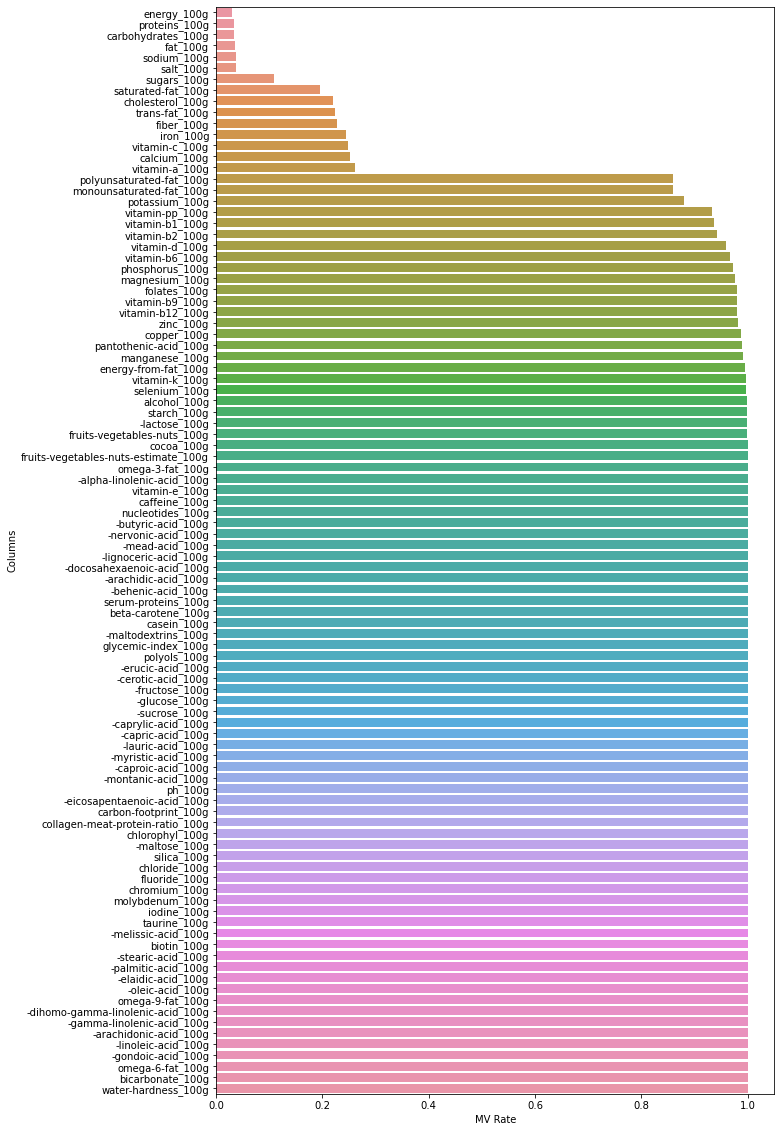

In [40]:
matplotlib.rcParams['figure.figsize'] = [10, 20]

sns.barplot("MV Rate", "Columns", data = nutrient_df_miss_vals, orient = "h")
plt.show()

In [42]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

0            energy_100g
49         proteins_100g
38    carbohydrates_100g
2               fat_100g
54           sodium_100g
             ...        
48            fiber_100g
77             iron_100g
61        vitamin-c_100g
75          calcium_100g
56        vitamin-a_100g
Name: Columns, Length: 15, dtype: object

In [44]:
less_missing_nutrient_df = nutrient_df[keep_cols]
less_missing_nutrient_df.head()

energy_100g  proteins_100g  carbohydrates_100g  fat_100g  sodium_100g  \
0          NaN            NaN                 NaN       NaN          NaN   
1       2243.0           3.57               64.29     28.57        0.000   
2       1941.0          17.86               60.71     17.86        0.250   
3       2540.0          17.86               17.86     57.14        0.482   
4       1552.0           8.57               77.14      1.43          NaN   

   salt_100g  sugars_100g  saturated-fat_100g  cholesterol_100g  \
0        NaN          NaN                 NaN               NaN   
1    0.00000        14.29               28.57             0.018   
2    0.63500        17.86                0.00             0.000   
3    1.22428         3.57                5.36               NaN   
4        NaN          NaN                 NaN               NaN   

   trans-fat_100g  fiber_100g  iron_100g  vitamin-c_100g  calcium_100g  \
0             NaN         NaN        NaN             NaN           NaN   
1             0.0         3.6    0.00129          0.0214         0.000   
2             0.0         7.1    0.00129          0.0000         0.071   
3             NaN         7.1    0.00514             NaN         0.143   
4             NaN         5.7        NaN             NaN           NaN   

   vitamin-a_100g  
0             NaN  
1             0.0  
2             0.0  
3             NaN  
4             NaN

In [45]:
less_missing_nutrient_df.shape

(20001, 15)

In [71]:
less_missing_nutrient_df.describe()

energy_100g  proteins_100g  carbohydrates_100g      fat_100g  \
count  19388.000000   19320.000000        19318.000000  19302.000000   
mean    1115.085403       6.468949           32.595135     12.484011   
std      822.108179       8.291655           29.442481     18.291818   
min        0.000000       0.000000            0.000000      0.000000   
25%      326.000000       0.000000            6.450000      0.000000   
50%     1105.000000       3.700000           21.430000      3.570000   
75%     1674.000000       9.260000           60.000000     20.000000   
max     5690.000000     100.000000          100.000000    100.000000   

        sodium_100g     salt_100g   sugars_100g  saturated-fat_100g  \
count  19257.000000  19257.000000  17838.000000        16087.000000   
mean       0.808699      2.054095     16.698567            4.995662   
std        4.637537     11.779343     21.484109            7.828253   
min        0.000000      0.000000     -1.200000            0.000000   
25%        0.024000      0.060960      1.760000            0.000000   
50%        0.250000      0.635000      6.670000            1.790000   
75%        0.595000      1.511300     25.000000            7.140000   
max      342.857000    870.856780    100.000000           92.860000   

       cholesterol_100g  trans-fat_100g    fiber_100g     iron_100g  \
count      15608.000000    15540.000000  15450.000000  15117.000000   
mean           0.019624        0.112249      2.656623      0.003374   
std            0.116848        3.193473      4.343886      0.164507   
min            0.000000        0.000000      0.000000      0.000000   
25%            0.000000        0.000000      0.000000      0.000000   
50%            0.000000        0.000000      1.400000      0.000900   
75%            0.022000        0.000000      3.600000      0.002250   
max           13.846000      369.000000    100.000000     19.200000   

       vitamin-c_100g  calcium_100g  vitamin-a_100g  
count    15037.000000  14963.000000    14780.000000  
mean         0.011128      0.131942        0.000144  
std          0.318358      4.280245        0.000601  
min          0.000000      0.000000        0.000000  
25%          0.000000      0.000000        0.000000  
50%          0.000000      0.033000        0.000000  
75%          0.002800      0.107000        0.000107  
max         35.714300    522.727000        0.025714

In [72]:
less_missing_nutrient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_100g         19388 non-null  float64
 1   proteins_100g       19320 non-null  float64
 2   carbohydrates_100g  19318 non-null  float64
 3   fat_100g            19302 non-null  float64
 4   sodium_100g         19257 non-null  float64
 5   salt_100g           19257 non-null  float64
 6   sugars_100g         17838 non-null  float64
 7   saturated-fat_100g  16087 non-null  float64
 8   cholesterol_100g    15608 non-null  float64
 9   trans-fat_100g      15540 non-null  float64
 10  fiber_100g          15450 non-null  float64
 11  iron_100g           15117 non-null  float64
 12  vitamin-c_100g      15037 non-null  float64
 13  calcium_100g        14963 non-null  float64
 14  vitamin-a_100g      14780 non-null  float64
dtypes: float64(15)
memory usage: 2.3 MB


In [48]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [50]:
otherVariableList = Diff(col, nutrient_list)

In [89]:
# other df

# use only 20000 rows temporarily for faster computation
other_df = df.loc[:, otherVariableList]

In [90]:
other_df_miss_vals = pd.DataFrame(other_df.isna().mean()).reset_index()
other_df_miss_vals.columns = ["Columns", "MV Rate"]
other_df_miss_vals = other_df_miss_vals.sort_values("MV Rate")
other_df_miss_vals

Columns   MV Rate
8                  last_modified_datetime  0.000000
11                        last_modified_t  0.000000
3                               created_t  0.000008
36                                creator  0.000008
5                        created_datetime  0.000028
..                                    ...       ...
0                            allergens_en  0.999944
58                     nutrition_grade_uk  1.000000
51              ingredients_from_palm_oil  1.000000
4   ingredients_that_may_be_from_palm_oil  1.000000
17                          no_nutriments  1.000000

[65 rows x 2 columns]

In [68]:
other_df_miss_vals = pd.DataFrame(other_df.isna().mean()).reset_index()
other_df_miss_vals.columns = ["Columns", "MV Rate"]
other_df_miss_vals = other_df_miss_vals.sort_values("MV Rate")

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


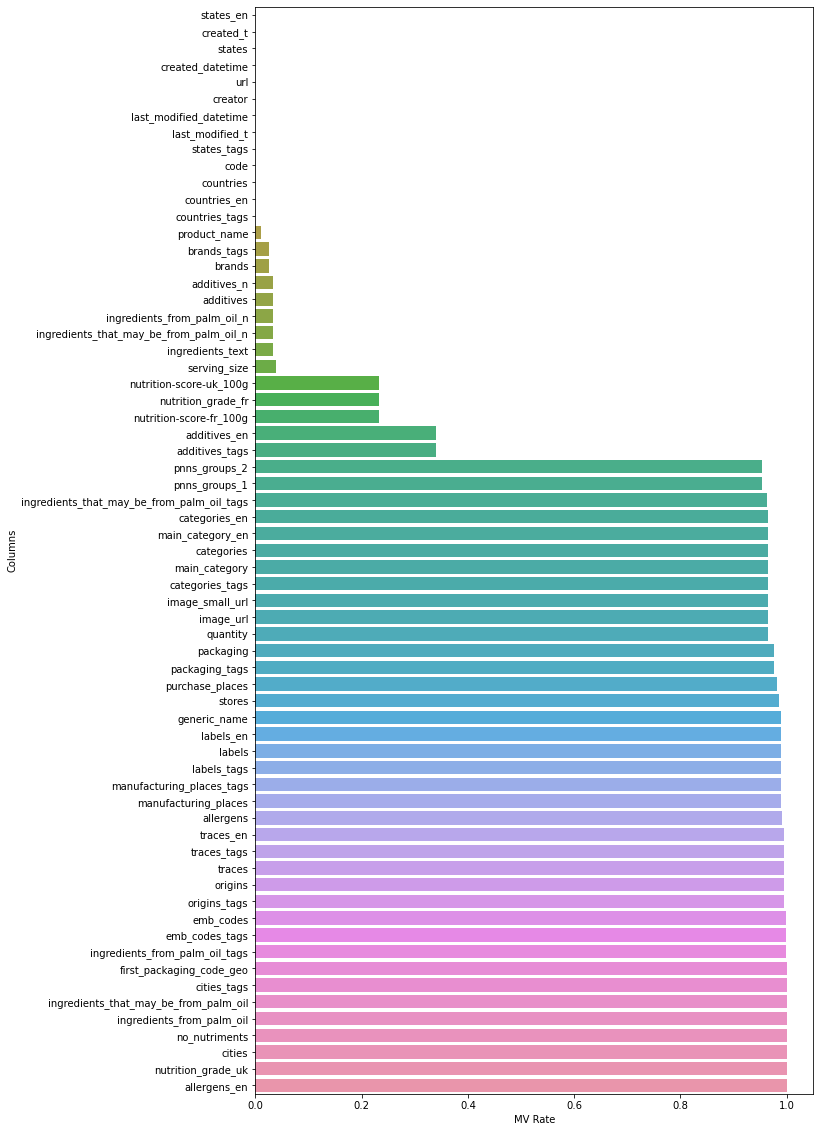

In [69]:
matplotlib.rcParams['figure.figsize'] = [10, 20]

sns.barplot("MV Rate", "Columns", data = other_df_miss_vals, orient = "h")
plt.show()

In [70]:
other_df.head()

allergens_en ingredients_that_may_be_from_palm_oil_tags  \
0          NaN                                        NaN   
1          NaN                                        NaN   
2          NaN                                        NaN   
3          NaN                                        NaN   
4          NaN                                        NaN   

                     product_name   created_t  \
0              Farine de blé noir  1474103866   
1  Banana Chips Sweetened (Whole)  1489069957   
2                         Peanuts  1489069957   
3          Organic Salted Nut Mix  1489055731   
4                 Organic Polenta  1489055653   

   ingredients_that_may_be_from_palm_oil      created_datetime  \
0                                    NaN  2016-09-17T09:17:46Z   
1                                    NaN  2017-03-09T14:32:37Z   
2                                    NaN  2017-03-09T14:32:37Z   
3                                    NaN  2017-03-09T10:35:31Z   
4                                    NaN  2017-03-09T10:34:13Z   

   nutrition-score-fr_100g emb_codes last_modified_datetime cities_tags  \
0                      NaN       NaN   2016-09-17T09:18:13Z         NaN   
1                     14.0       NaN   2017-03-09T14:32:37Z         NaN   
2                      0.0       NaN   2017-03-09T14:32:37Z         NaN   
3                     12.0       NaN   2017-03-09T10:35:31Z         NaN   
4                      NaN       NaN   2017-03-09T10:34:13Z         NaN   

  packaging_tags last_modified_t  \
0            NaN      1474103893   
1            NaN      1489069957   
2            NaN      1489069957   
3            NaN      1489055731   
4            NaN      1489055653   

                                         states_tags additives_tags  \
0  en:to-be-completed,en:nutrition-facts-to-be-co...            NaN   
1  en:to-be-completed,en:nutrition-facts-complete...            NaN   
2  en:to-be-completed,en:nutrition-facts-complete...            NaN   
3  en:to-be-completed,en:nutrition-facts-complete...            NaN   
4  en:to-be-completed,en:nutrition-facts-complete...            NaN   

                                    ingredients_text    countries_tags  \
0                                                NaN         en:france   
1  Bananas, vegetable oil (coconut oil, corn oil ...  en:united-states   
2  Peanuts, wheat flour, sugar, rice flour, tapio...  en:united-states   
3  Organic hazelnuts, organic cashews, organic wa...  en:united-states   
4                                    Organic polenta  en:united-states   

  categories_en  no_nutriments pnns_groups_2 first_packaging_code_geo  \
0           NaN            NaN           NaN                      NaN   
1           NaN            NaN           NaN                      NaN   
2           NaN            NaN           NaN                      NaN   
3           NaN            NaN           NaN                      NaN   
4           NaN            NaN           NaN                      NaN   

  labels_tags                                          additives quantity  \
0         NaN                                                NaN      1kg   
1         NaN   [ bananas -> en:bananas  ]  [ vegetable-oil -...      NaN   
2         NaN   [ peanuts -> en:peanuts  ]  [ wheat-flour -> ...      NaN   
3         NaN   [ organic-hazelnuts -> en:organic-hazelnuts  ...      NaN   
4         NaN   [ organic-polenta -> en:organic-polenta  ]  [...      NaN   

  manufacturing_places stores labels           brands origins_tags traces  \
0                  NaN    NaN    NaN  Ferme t'y R'nao          NaN    NaN   
1                  NaN    NaN    NaN              NaN          NaN    NaN   
2                  NaN    NaN    NaN   Torn & Glasser          NaN    NaN   
3                  NaN    NaN    NaN        Grizzlies          NaN    NaN   
4                  NaN    NaN    NaN   Bob's Red Mill          NaN    NaN   

  nutrition_grade_fr allergens generic

#### by Countries

In [81]:
other_df["countries_en"].unique()

array(['France', 'United States', 'United Kingdom',
       'France,United States', 'Canada', 'Switzerland', 'Spain',
       'Germany', 'Slovenia', 'Bangladesh', 'Italy', 'Romania',
       'Australia', 'Portugal', 'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe',
       'United Kingdom,United States', 'Dominican Republic',
       'Canada,United States', 'Netherlands', 'Australia,France',
       'Canada,France,Switzerland,United States', 'Ireland',
       'France,Réunion', 'Taiwan', 'Australia,Belgium,Switzerland',
       'France,Germany', 'Brazil', 'Belgium,France',
       'Australia,United States', 'Mexico', 'Saudi Arabia',
       'United Arab Emirates', 'Iraq', 'Kuwait', 'Moldova', 'France,Iraq',
       'New Caledonia', nan, 'Singapore', 'Finland',
       'Sweden,United States', 'French Polynesia', 'France,Switzerland',
       'Australia,New Zealand,Singapore,Thailand,United States',
       'France,French Polynesia', 'Panama', 'Costa Rica',
   

In [75]:
other_df["countries_en"].isna().mean()

0.00014999250037498125

In [92]:
other_df.shape

(356027, 65)

In [96]:
country = other_df['countries_en'].value_counts().head(20).to_frame()
country_count = country.style.background_gradient(cmap='Reds')
country_count

#### by Brands

In [94]:
brands = other_df['brands'].value_counts().head(20).to_frame()
brands_count = brands.style.background_gradient(cmap='Reds')
brands_count

In [79]:
other_df["additives_en"].unique()

array([nan, 'E307c - Tocopherol', 'E322 - Lecithins,E322i - Lecithin',
       ..., 'E339 - Sodium phosphates,E508 - Potassium chloride',
       'E101 - Riboflavin,E101i - Riboflavin,E129 - Allura red ac,E375 - Nicotinic acid',
       'E101 - Riboflavin,E101i - Riboflavin,E129 - Allura red ac,E330 - Citric acid,E375 - Nicotinic acid'],
      dtype=object)

## Need a research question

comparing nutrients by countries?

comparing nutrients by brands?

- Comparing macro nutrients of sugary snacks across countries /on artifical sweetener, natrual sweetener etc.

- Comparing salty snacks across countries on saturated fat, trans fat etc.





### New approach: Can we identify meaningful clusters of ingredients by clustering on the macronutrient profiles of different food products?

In [3]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

In [4]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [8]:
clean_ingre = lambda s: " ".join(map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )


In [9]:
clust_df["ingredients_text"] = [clean_ingre(i) for i in clust_df["ingredients_text"]]

In [11]:
clust_df.iloc[0,0]

'bananas vegetable-oil coconut-oil corn-oil-and/or-palm-oil sugar natural-banana-flavor'

## Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are not in the the most common words list are dropped

In [15]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [18]:
most_common_words = dict(Counter(all_words).most_common(1000))

##### keep only the food with all its ingredients are common ingredients

In [23]:
clust_df = clust_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clust_df['ingredients_text']]]


##### Remove outliers

In [25]:
clust_df = clust_df[(np.abs(stats.zscore(clust_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [30]:
clust_df.shape

(12277, 7)

In [27]:
for col in keep_cols[1:]:
    clust_df[col] = scale(np.array(clust_df[col]))

In [33]:
scaledX = clust_df.iloc[:,1:]

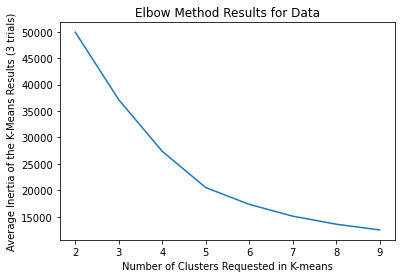

In [34]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

### K-means

In [67]:
n_clust = 5

In [68]:
X = np.array(clust_df.drop(["ingredients_text"], axis = 1))
kmeans = KMeans(n_clusters = n_clust, random_state = 69).fit(X)

In [69]:
clust_df['clust'] = kmeans.labels_


In [70]:
clust_df.groupby('clust').mean()

carbohydrates_100g  fiber_100g  sugars_100g  proteins_100g  fat_100g  \
clust                                                                         
0                1.427311    0.406548    -0.381436       0.043718 -0.454492   
1               -0.623430   -0.414982    -0.293650      -0.593003 -0.654353   
2               -0.875764   -0.756343    -0.584931       1.371693  0.754393   
3               -0.212618    1.845455    -0.361724       0.913095  1.955322   
4                1.356121    0.069066     2.178611      -0.562040 -0.025720   

       saturated-fat_100g  
clust                      
0               -0.560376  
1               -0.571947  
2                1.664455  
3                0.158471  
4                0.328622

In [71]:
clust_df.groupby('clust').count()

ingredients_text  carbohydrates_100g  fiber_100g  sugars_100g  \
clust                                                                  
0                  1946                1946        1946         1946   
1                  5150                5150        5150         5150   
2                  1932                1932        1932         1932   
3                  1454                1454        1454         1454   
4                  1795                1795        1795         1795   

       proteins_100g  fat_100g  saturated-fat_100g  
clust                                               
0               1946      1946                1946  
1               5150      5150                5150  
2               1932      1932                1932  
3               1454      1454                1454  
4               1795      1795                1795

#### WE USE TD-IDF TO DEFINE WORD PREVELANCE BY CLUSTER

In [72]:
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])


In [73]:
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [74]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [75]:
tot_word_counts = dict(Counter(all_words))

In [77]:
### TD IDF
N = clust_df.shape[0]

## WE USE TD-IDF TO DEFINE WORD PREVELANCE BY CLUSTER¶

In [78]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common())
    
    ### TF IDF To Obtain True Cluster Prevelance 
    for key in clust_word_counts.keys():
        clust_word_counts[key] = clust_word_counts[key] * np.log(N / tot_word_counts[key])
    
    return clust_word_counts

In [79]:
clust_words = clust_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)


                 ingredients_text
niacin                2013.105343
riboflavin            1983.935863
folic-acid            1956.303251
iron                  1677.868142
ferrous-sulfate       1609.420794


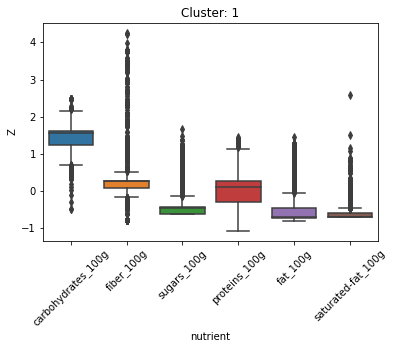

               ingredients_text
citric-acid         1741.754312
green-beans         1191.414808
ascorbic-acid       1156.546455
tomatoes            1109.536551
shrimp              1108.080037


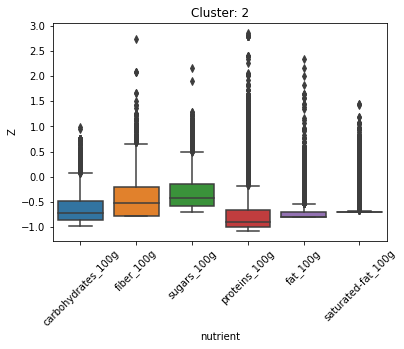

                            ingredients_text
enzymes                          2808.673873
pasteurized-milk                 2126.890217
cheese-culture                   1981.631286
cheese-cultures                  1186.805923
pasteurized-part-skim-milk       1134.519604


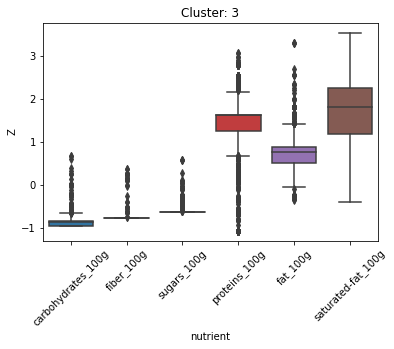

            ingredients_text
almonds          1340.068469
peanuts          1004.812435
peanut-oil        858.706212
pecans            849.084381
walnuts           741.622681


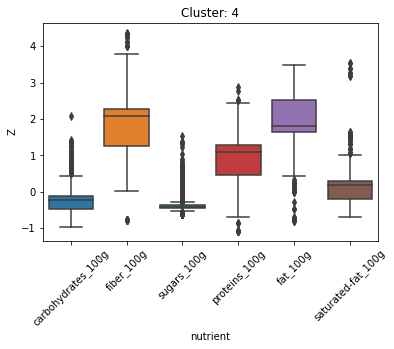

                  ingredients_text
cocoa-butter           1356.914339
corn-syrup             1325.137227
soy-lecithin           1288.753179
chocolate-liquor        984.325984
vanilla                 921.075310


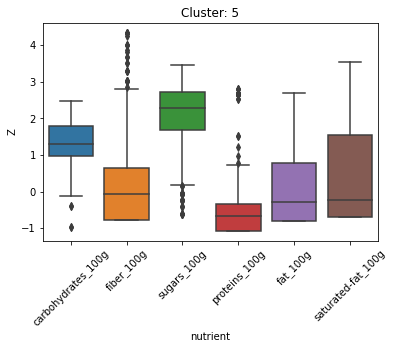

In [81]:
for c in range(n_clust):
    print(pd.DataFrame(clust_words[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.clust == c]
    plot_df = pd.DataFrame(temp_df.drop(['clust', 'ingredients_text'], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

## Hierarchical

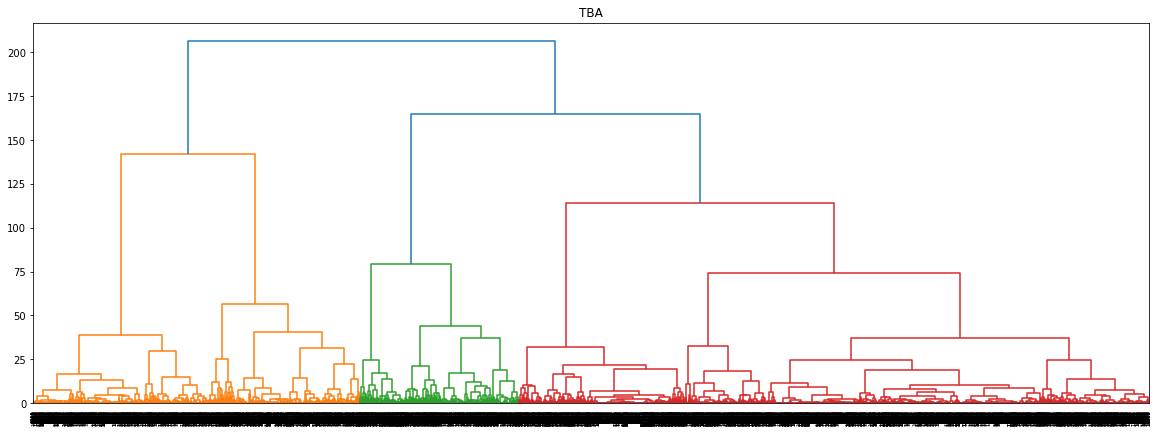

In [89]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("TBA")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(clust_df.drop(["ingredients_text", "clust"], axis = 1), method='ward'))

In [90]:
agc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

clust_df['hierarchical5'] = agc.fit_predict(clust_df.drop(["ingredients_text", "clust"], axis = 1))

In [91]:
clust_words2 = clust_df.groupby('hierarchical5')['ingredients_text'].apply(clust_word_prevelance)


                  ingredients_text
cocoa-butter           1370.349134
corn-syrup             1317.608038
soy-lecithin           1252.450273
chocolate-liquor        991.782999
vanilla                 913.556328


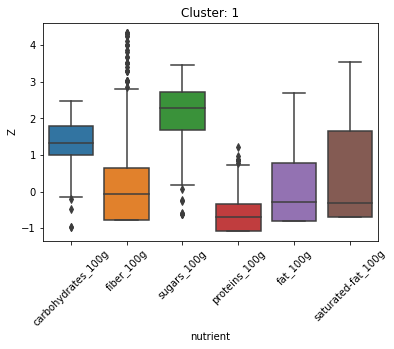

            ingredients_text
almonds          1343.177677
peanuts          1011.511184
peanut-oil        878.401308
pecans            863.787141
walnuts           741.622681


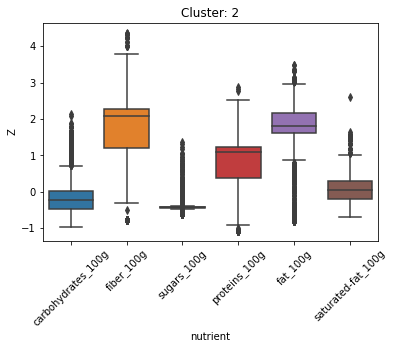

               ingredients_text
citric-acid         1724.797037
green-beans         1191.414808
vitamin-d3          1188.919963
ascorbic-acid       1153.041769
tomatoes            1109.536551


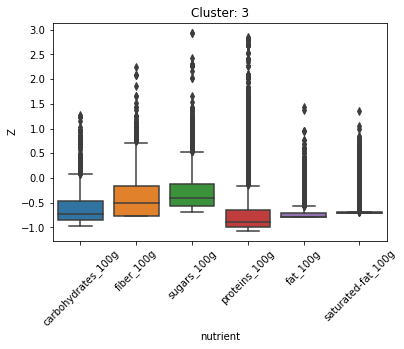

                            ingredients_text
enzymes                          2793.131804
pasteurized-milk                 2137.618541
cheese-culture                   1978.792272
cheese-cultures                  1165.612960
pasteurized-part-skim-milk       1083.283235


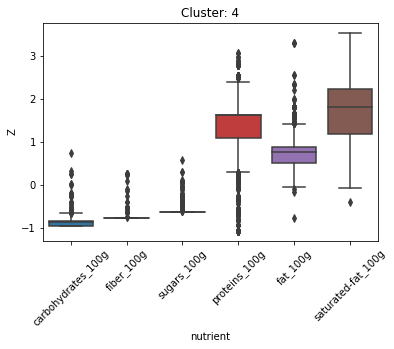

                 ingredients_text
niacin                2100.631663
folic-acid            2072.870543
riboflavin            2052.522634
iron                  1662.474856
ferrous-sulfate       1590.298962


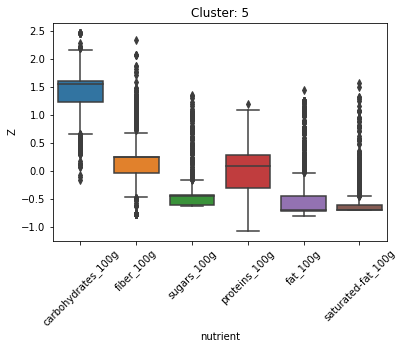

In [107]:
for c in range(5):
    print(pd.DataFrame(clust_words2[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.hierarchical5 == c]
    plot_df = pd.DataFrame(temp_df.drop(['hierarchical5', 'ingredients_text', 'clust'], axis = 1).stack()).reset_index()
    plot_df.columns = ['unused', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

## Self Origanizing Map

In [109]:
import SimpSOM as sps

In [122]:
Xdf = clust_df.drop(["ingredients_text", "clust", "hierarchical5"], axis = 1)

In [120]:
Xst = clust_df.drop(["ingredients_text", "clust", "hierarchical5"], axis = 1).to_numpy()

In [130]:
np.random.seed(1000)
net = sps.somNet(20, 20, Xst)
net.train(0.01, 20000)

Periodic Boundary Conditions inactive.
The weights will be initialised randomly.
Training SOM... done!


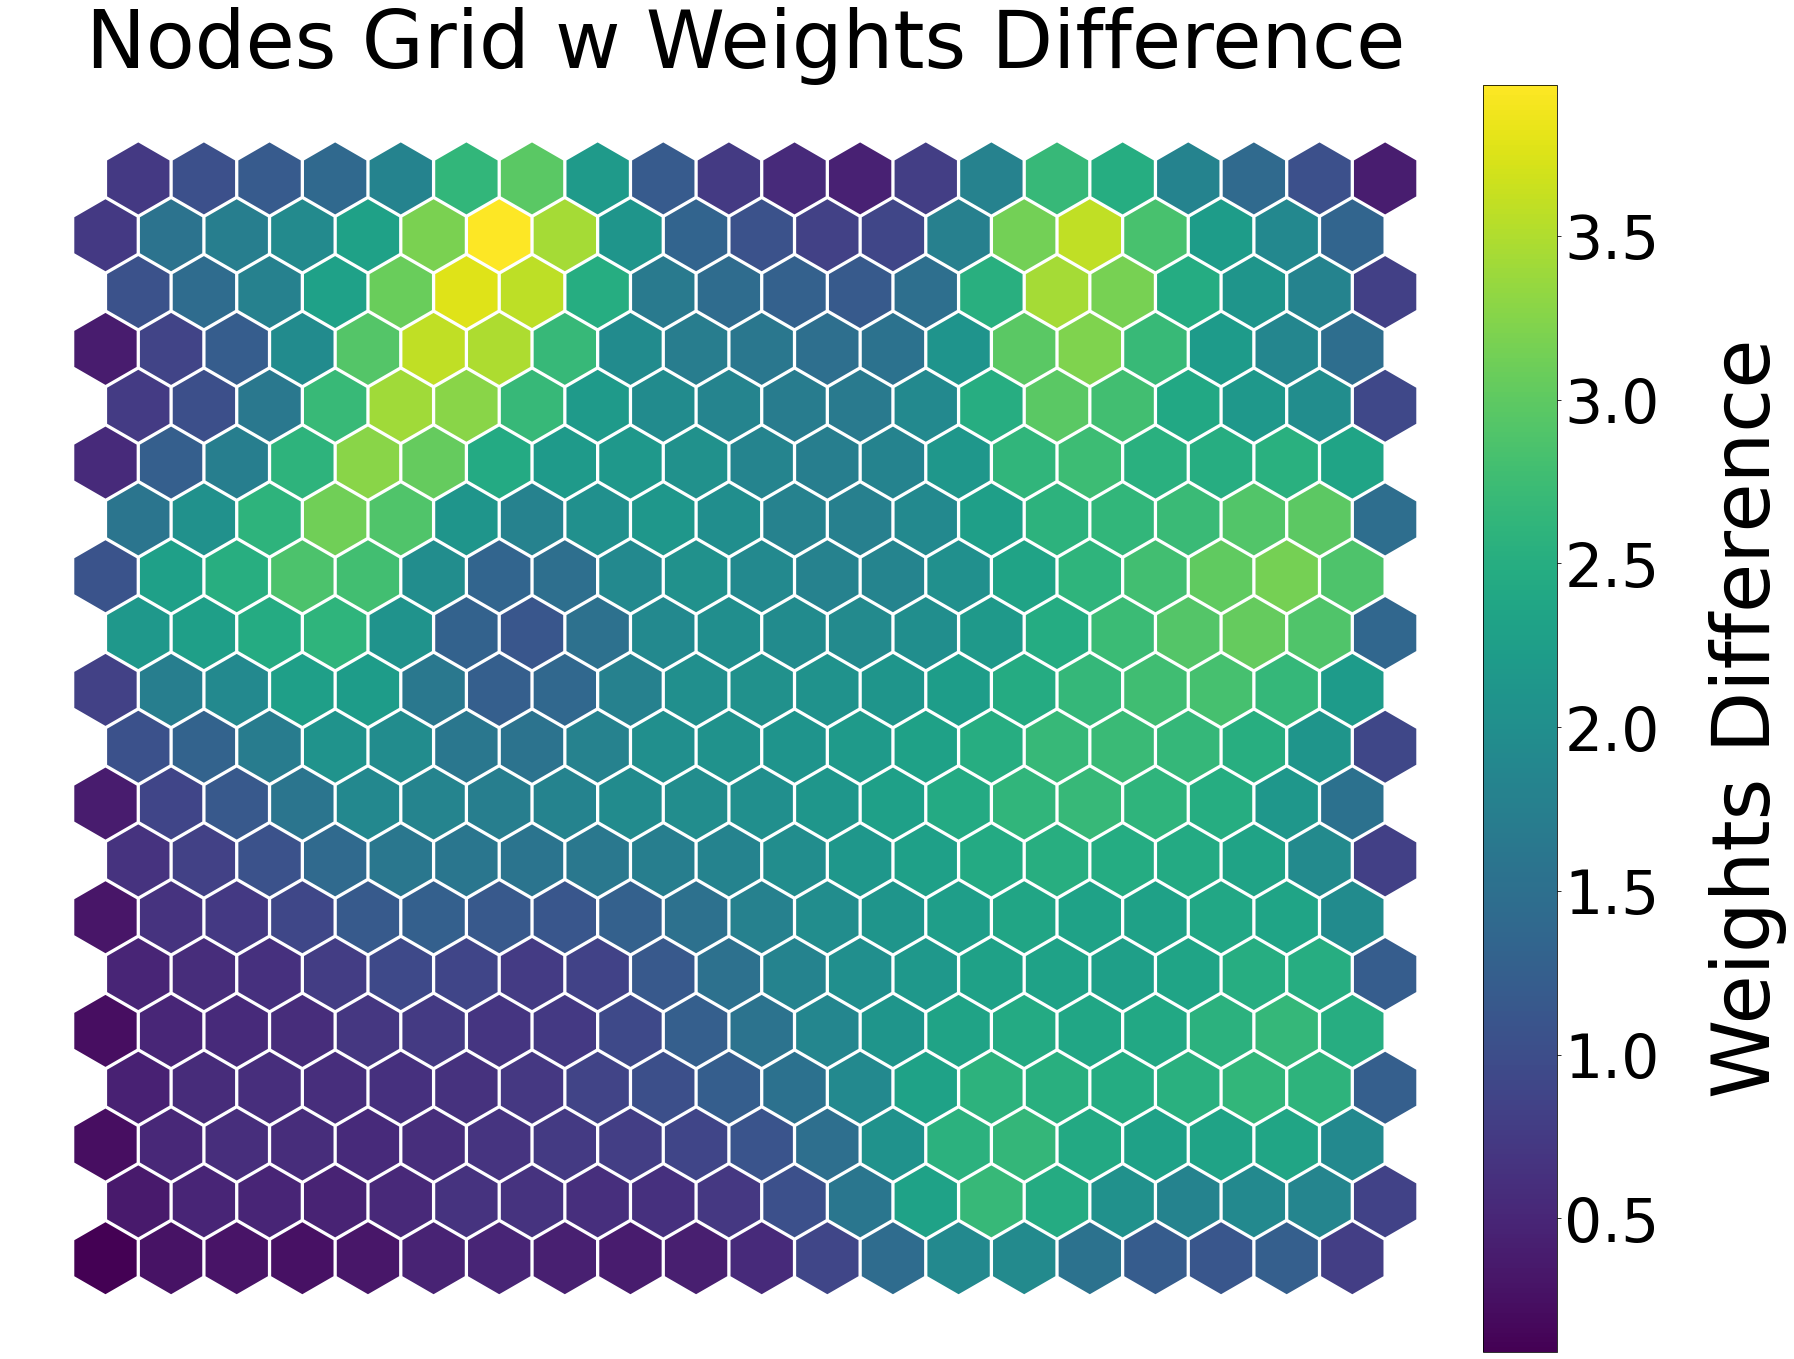

<Figure size 432x288 with 0 Axes>

In [131]:
net.diff_graph(show=True, printout=True)

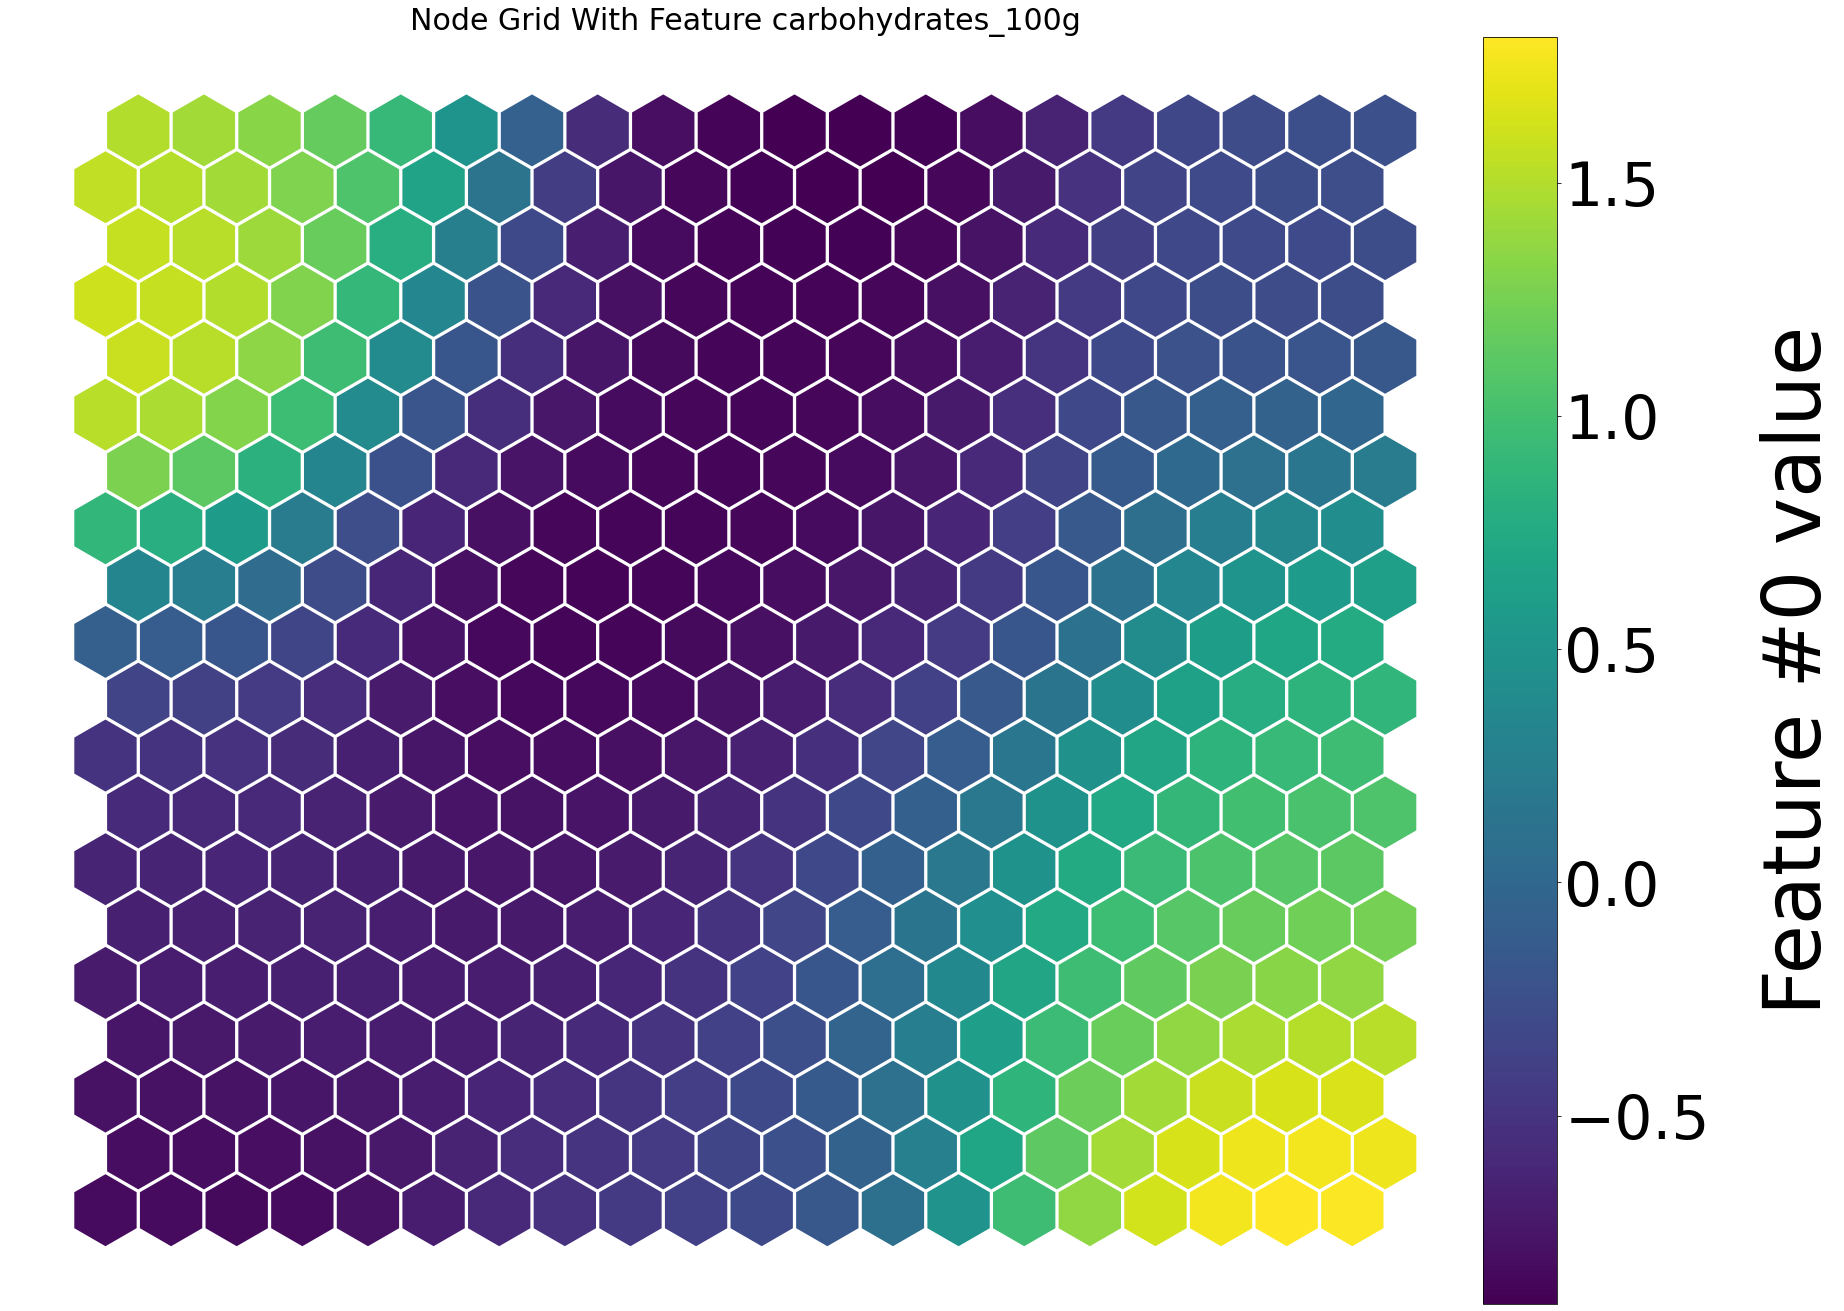

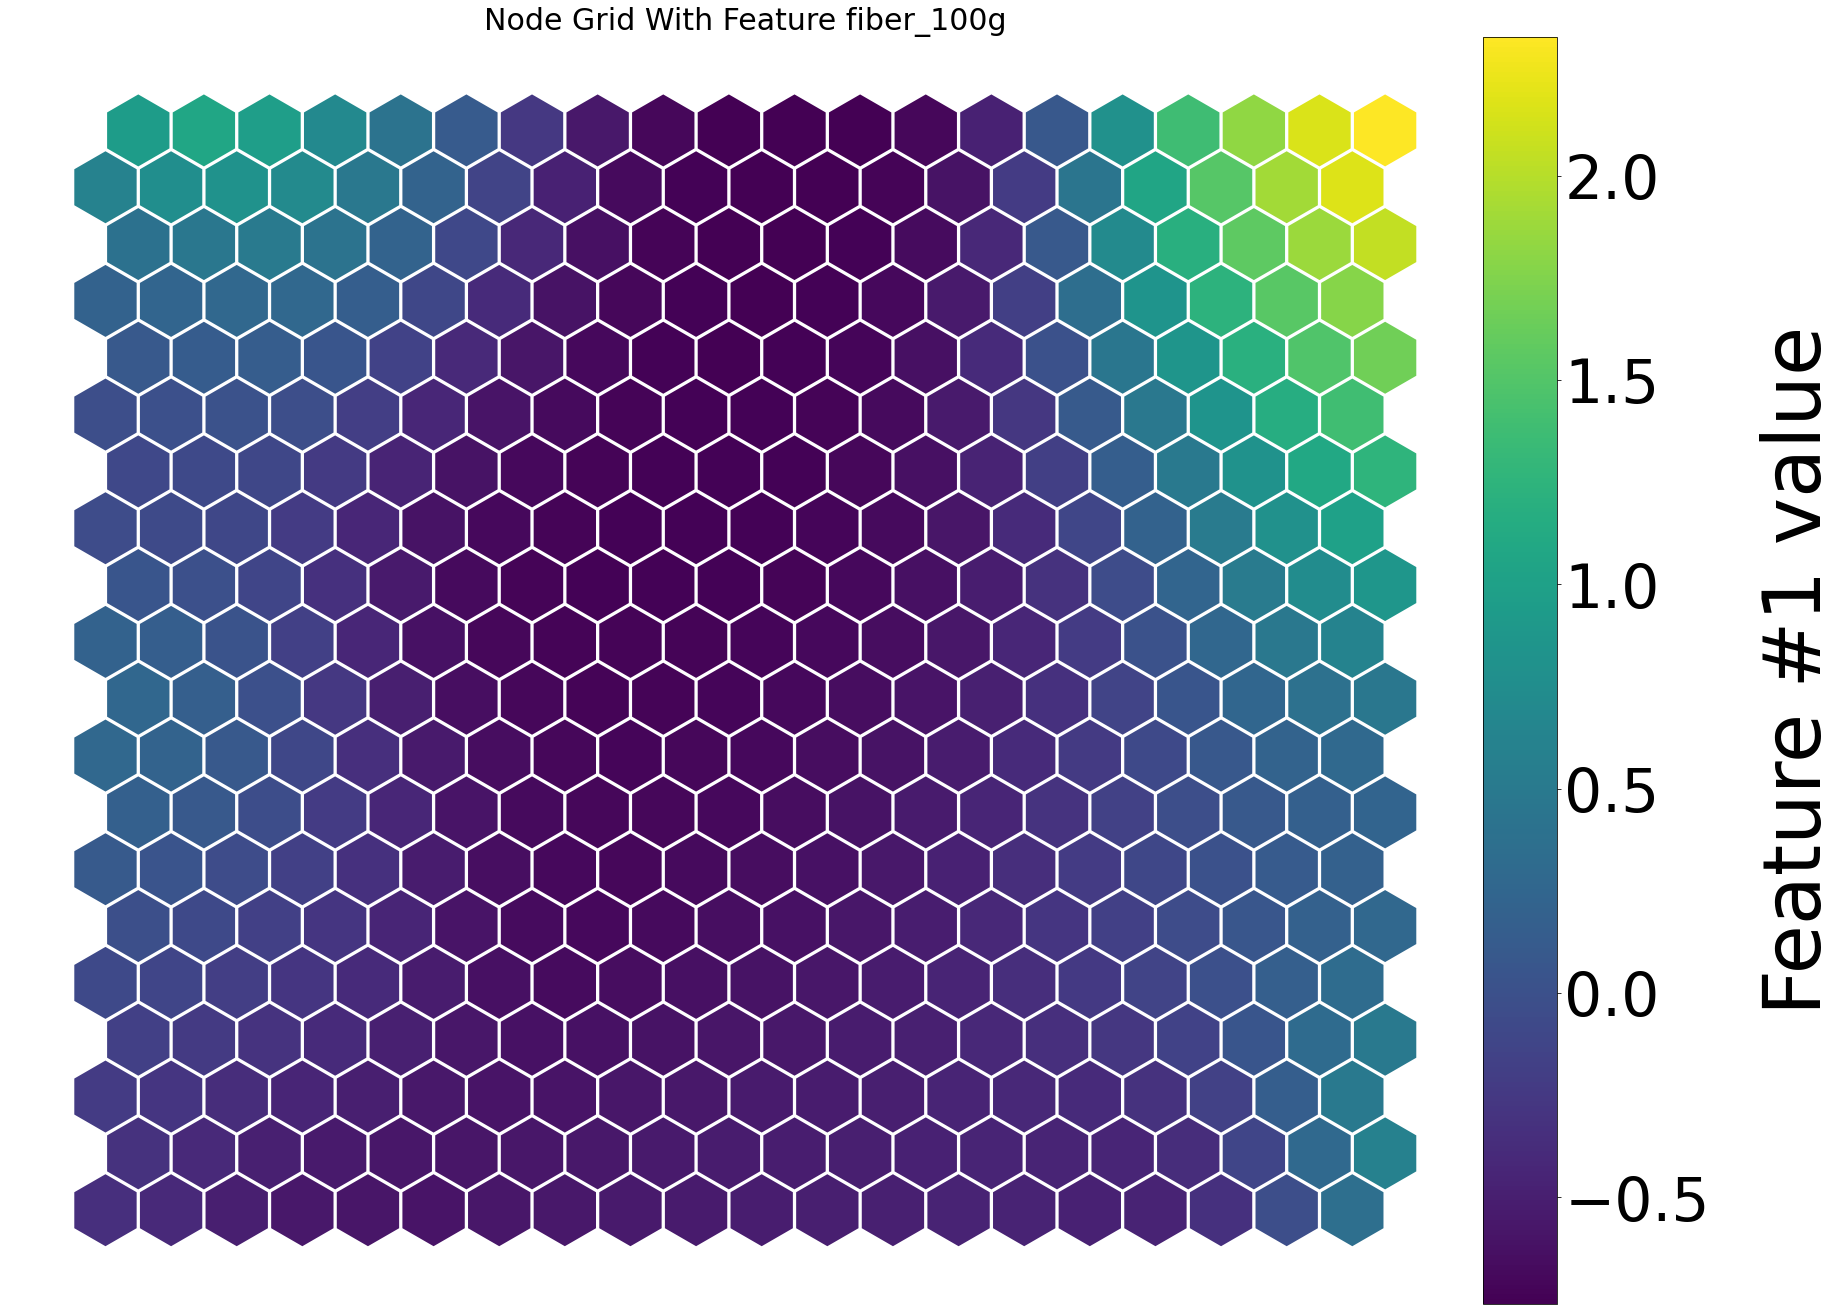

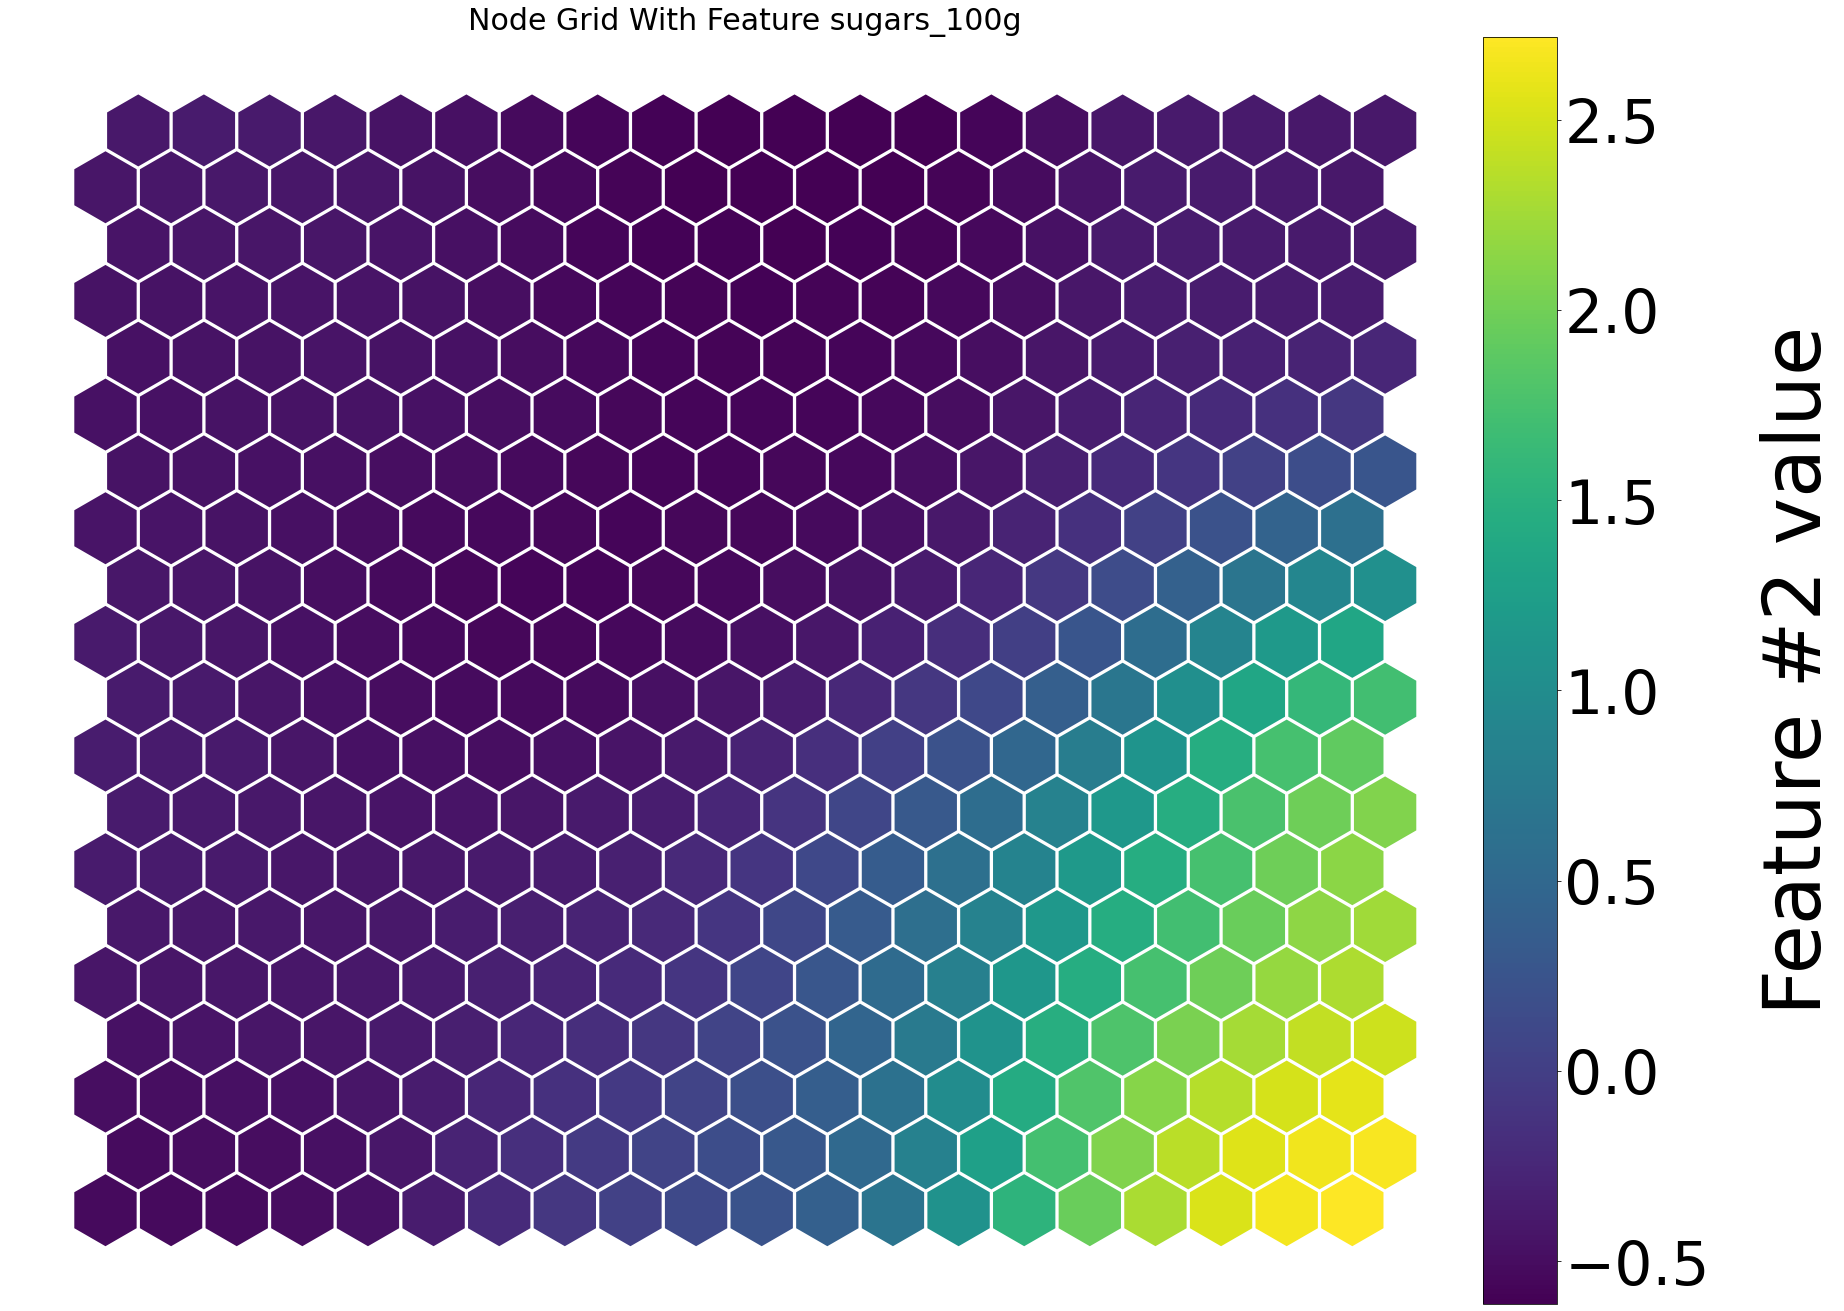

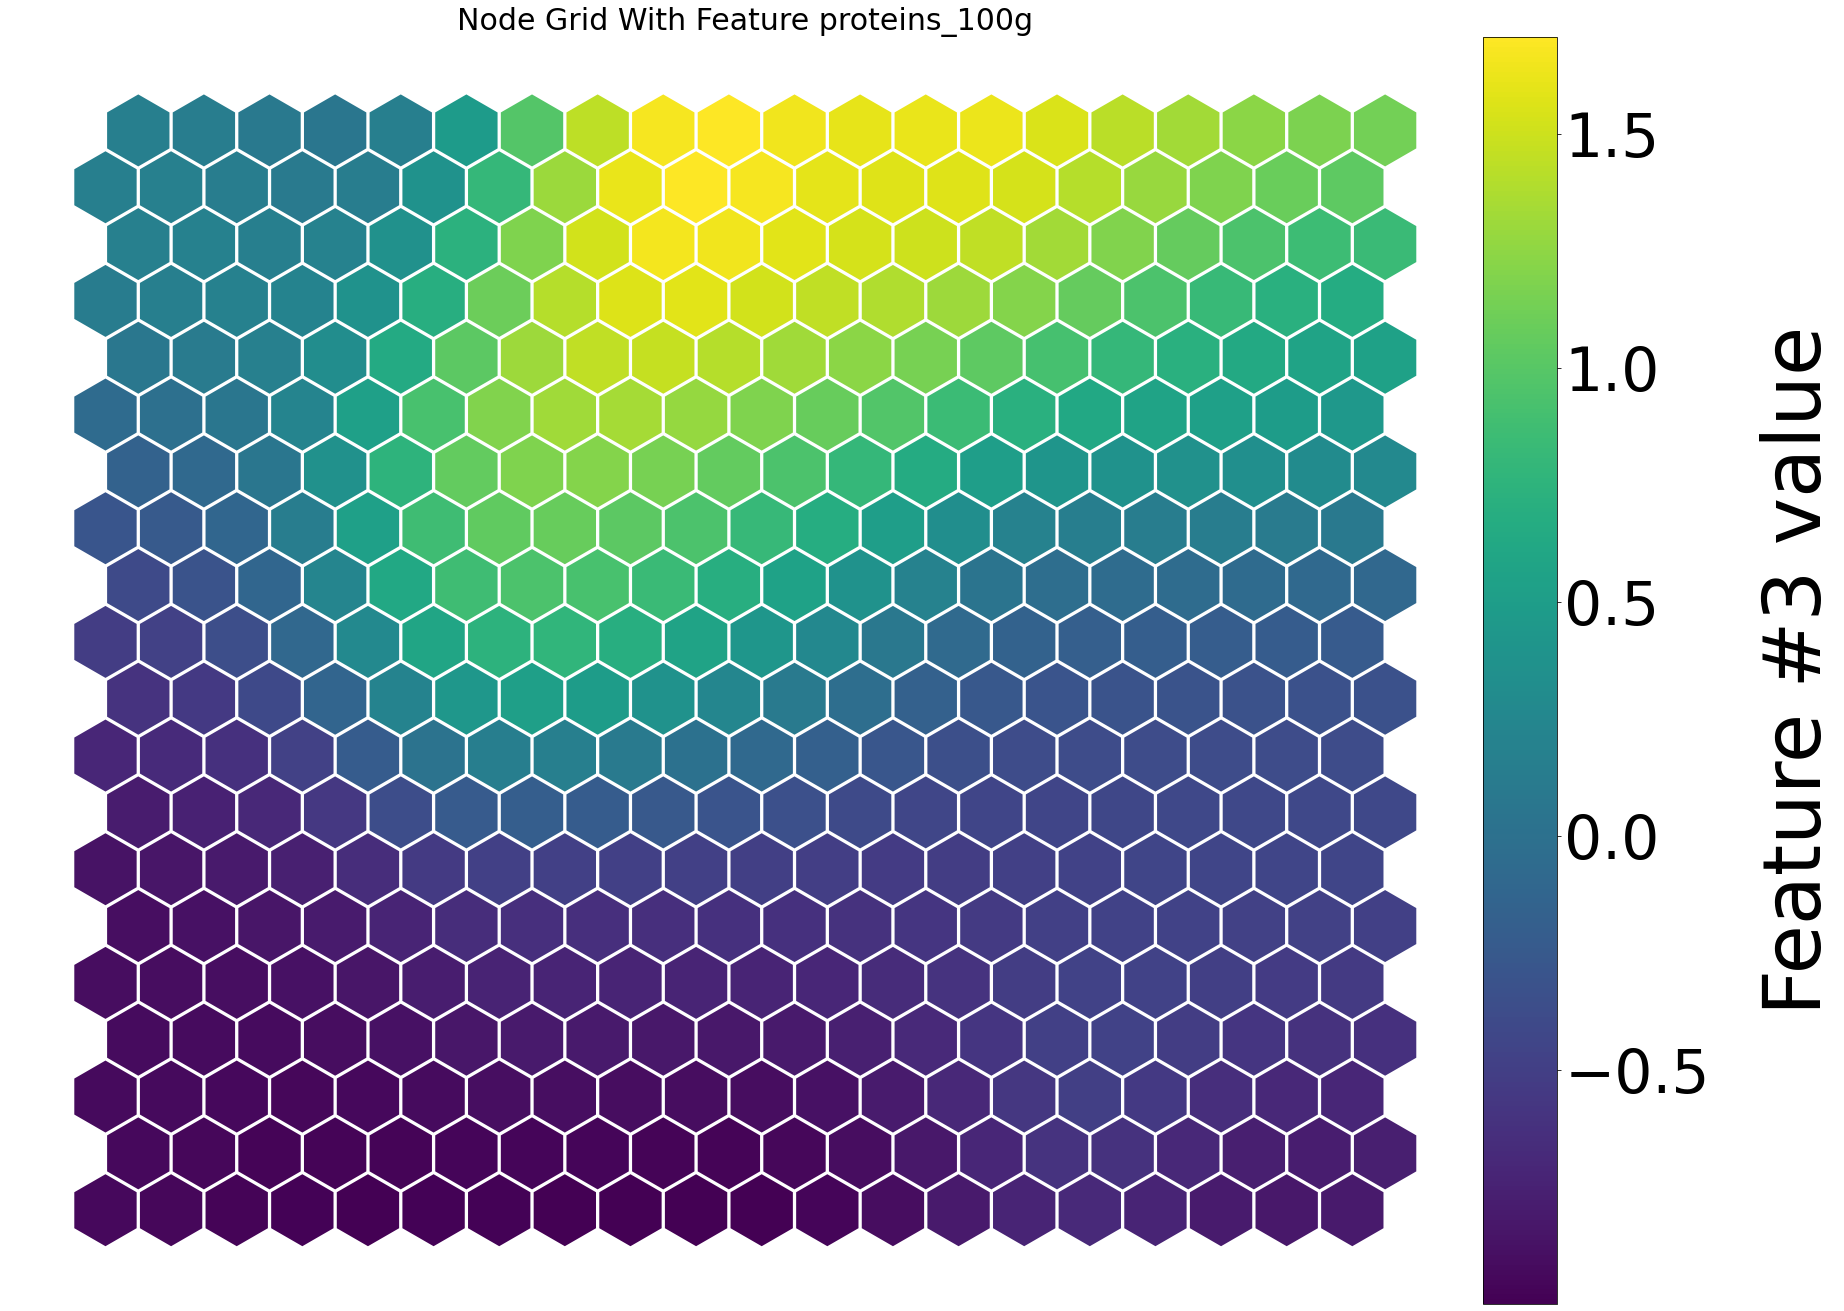

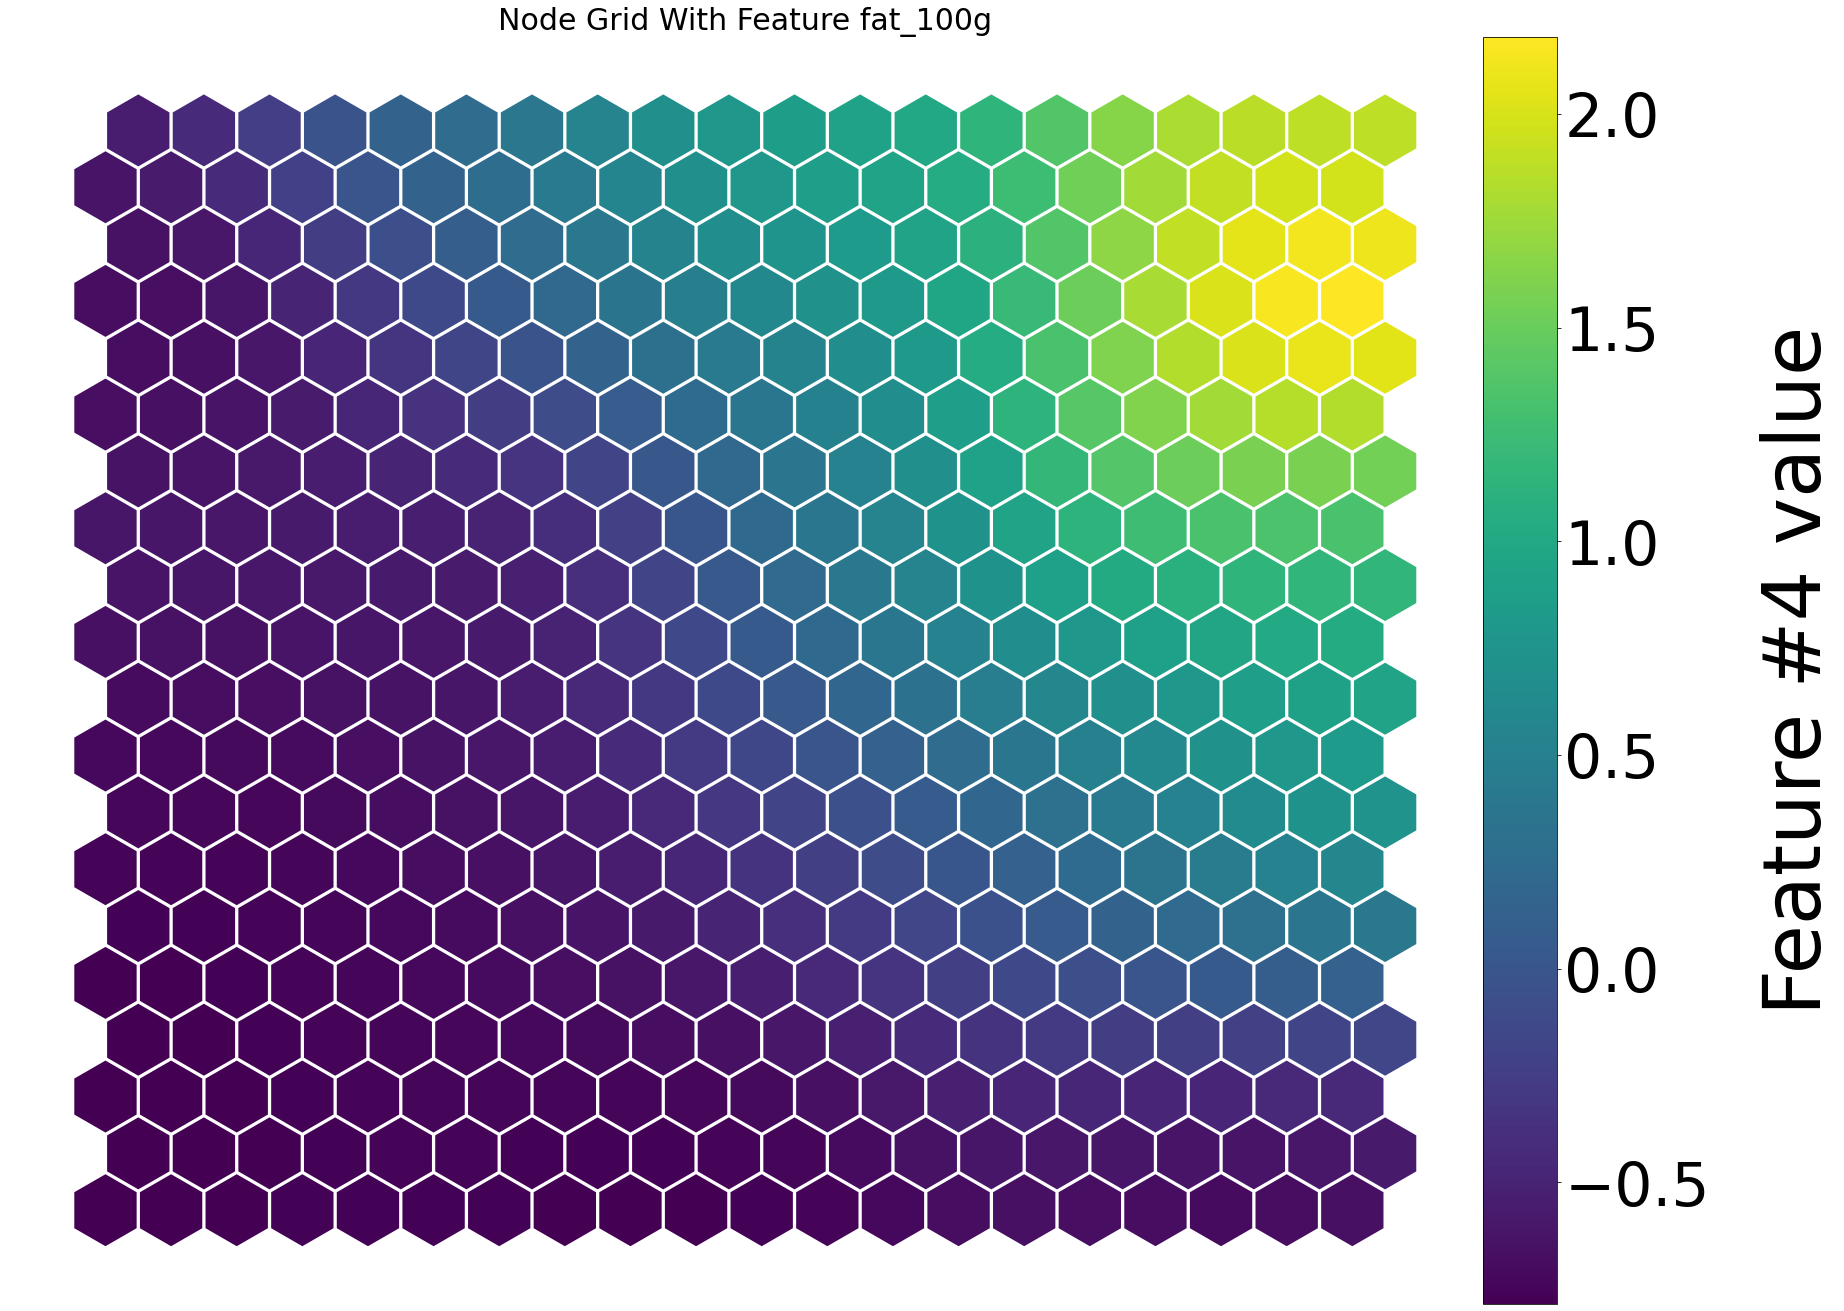

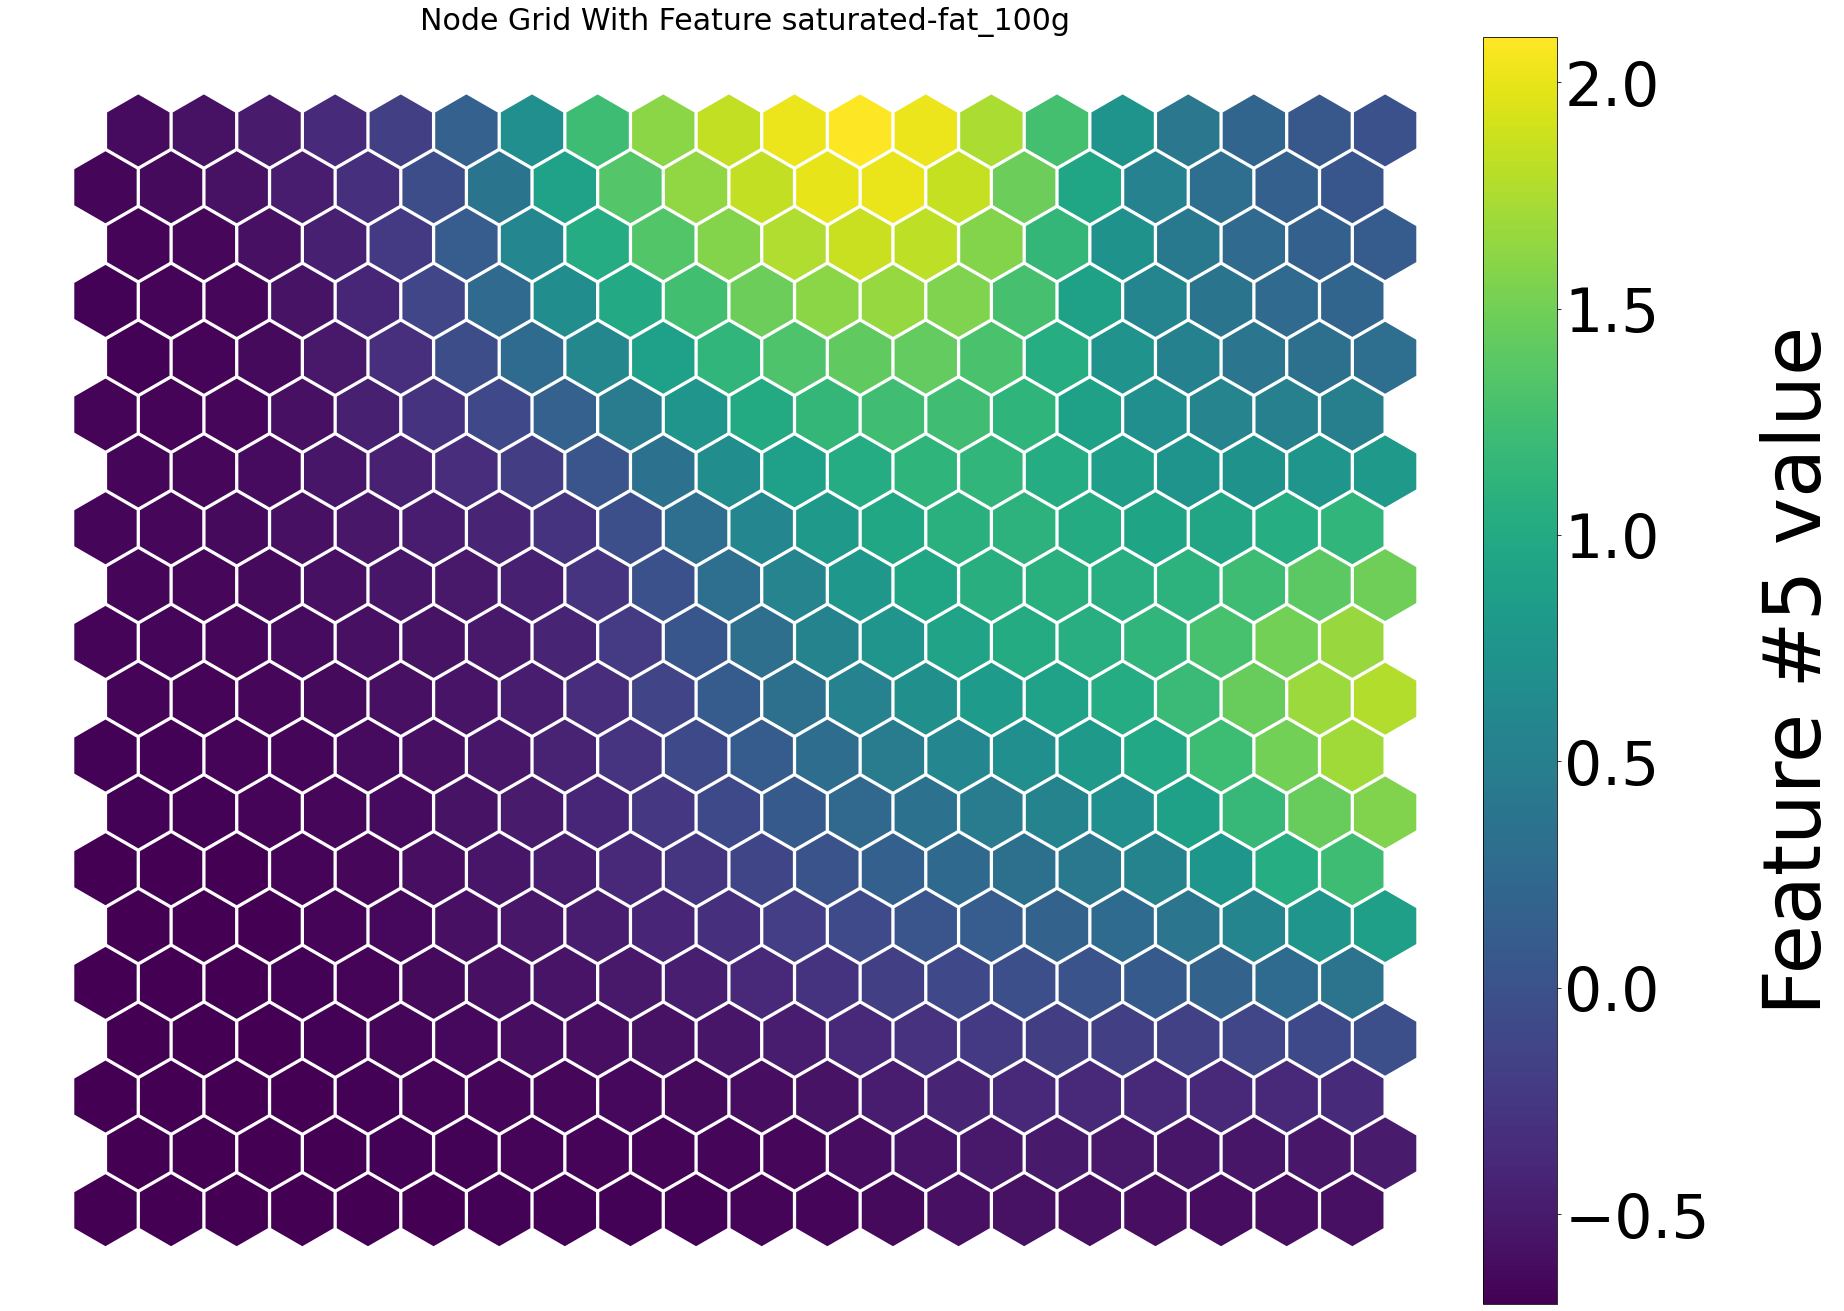

In [132]:
for i in range(0,len(Xdf.columns)):
    net.nodes_graph(colnum=i, printout=True)
    plt.title('Node Grid With Feature '+ Xdf.columns[i], size=30)
    plt.show()

#### Looking at the carbonhydrate map, it suggests there exists two groups of observations with high carbonhydrate. One of them is highly proportionally correlated to sugar(c5 in kmeans) (c1 in hclust), while the other group is more correlated with fiber and protein.(c1 in kmeans) (c5 in hclust)

#### Looking at the fiber, protein, fat, saturated fat map, they suggests that fiber, protein, fat and saturated fat are somewhat proportionally correlated.  (c3, c4 in kmeans) (c4, c2 in hclust)


# New Idea: cluster macro nutrients by level of nutri-score

https://archpublichealth.biomedcentral.com/articles/10.1186/s13690-019-0357-x

https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/

In [3]:
nutrientByCountries = ['countries_en', 'main_category', "energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g", "nutrition-score-fr_100g"]
cluster_df = df[nutrientByCountries]
cluster_df = cluster_df.dropna()


In [4]:
cluster_df.shape

(71473, 10)

In [5]:
cluster_df.head()

countries_en                       main_category  energy_100g  \
176       Canada  en:plant-based-foods-and-beverages       1210.0   
182       Canada                    en:sugary-snacks       1090.0   
183       Canada                         fr:boulange       1160.0   
185       France                        en:beverages        215.0   
187       Canada                            en:meals        478.0   

     proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
176          22.00       0.8500               7.000     12.00   
182           3.33       0.2550               2.000     10.70   
183          10.00       0.6000               0.333      1.11   
185           0.00       0.0242               0.000      0.00   
187           5.36       0.1960               2.860      6.79   

     carbohydrates_100g  sugars_100g  nutrition-score-fr_100g  
176               23.00        0.000                      6.0  
182               38.70       24.700                      9.0  
183               53.30        1.110                      1.0  
185               14.20       13.600                     18.0  
187                7.86        0.714                      2.0

In [21]:
cluster_df["nutrition-score-fr_100g"].describe()

count    71473.000000
mean         8.620612
std          8.956984
min        -15.000000
25%          1.000000
50%          9.000000
75%         15.000000
max         40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [35]:
cluster_df["main_category"].value_counts()[1:25]

en:sugary-snacks               10345
en:beverages                    6813
en:dairies                      6207
en:meats                        3807
en:groceries                    3681
en:fresh-foods                  2913
en:meals                        2503
en:salty-snacks                 2059
en:fruit-juices                 1694
en:frozen-foods                 1548
en:spreads                      1537
en:canned-foods                 1428
en:seafood                      1196
en:desserts                     1172
en:fats                          759
en:sandwiches                    666
en:baby-foods                    478
en:sweeteners                    367
en:fruit-juices-and-nectars      325
en:breakfasts                    295
en:waffles                       230
en:pickles                       198
en:farming-products              182
en:green-olives                  162
Name: main_category, dtype: int64

In [6]:
solidFood = ['en:sugary-snacks', 'en:dairies', 'en:meats',
       'en:groceries', 'en:fresh-foods', 'en:meals', 'en:salty-snacks',
        'en:frozen-foods', 'en:spreads', 'en:canned-foods',
       'en:seafood', 'en:desserts', 'en:fats', 'en:sandwiches',
       'en:baby-foods', 'en:sweeteners', 'en:breakfasts', 'en:waffles', 'en:pickles', 'en:farming-products']

In [39]:
cluster_df['countries_en'].value_counts().head(10)

France                52313
Germany                4613
Spain                  2507
United States          1750
Switzerland            1616
United Kingdom         1408
France,Switzerland      950
Belgium,France          537
Belgium                 502
Australia               452
Name: countries_en, dtype: int64

In [7]:
solidFoodDF = cluster_df[cluster_df.main_category.isin(solidFood)]


In [8]:
solidFoodDF.head()

countries_en     main_category  energy_100g  proteins_100g  \
182          Canada  en:sugary-snacks       1090.0           3.33   
187          Canada          en:meals        478.0           5.36   
189          France  en:sugary-snacks       1667.0           0.00   
227  United Kingdom       en:desserts       1284.0           3.90   
228  United Kingdom  en:sugary-snacks       1284.0           3.90   

     sodium_100g  saturated-fat_100g  fat_100g  carbohydrates_100g  \
182      0.25500                2.00     10.70               38.70   
187      0.19600                2.86      6.79                7.86   
189      0.00000                0.00      0.00               93.30   
227      0.07874                3.60      7.00               54.20   
228      0.07870                3.60      7.00               54.20   

     sugars_100g  nutrition-score-fr_100g  
182       24.700                      9.0  
187        0.714                      2.0  
189       93.300                     14.0  
227       44.000                     10.0  
228       44.000                     10.0

In [82]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://46vbgn3y13aq29shrj4arjn4-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/Nutri-Score-overview.png",\
      width = 600, height = 800)

In [9]:
solidFoodDF['Nutri-score'] = pd.cut(solidFoodDF['nutrition-score-fr_100g'], [-15, -1, 2, 10, 18, 42],\
                                    labels=['A', 'B', 'C', 'D', 'E'])


<ipython-input-9-5e4e3c1ef281>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solidFoodDF['Nutri-score'] = pd.cut(solidFoodDF['nutrition-score-fr_100g'], [-15, -1, 2, 10, 18, 42],\


In [10]:
solidFoodDF.drop(["countries_en", "nutrition-score-fr_100g"], axis = 1, inplace = True)

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
solidFoodDF.head()

main_category  energy_100g  proteins_100g  sodium_100g  \
182  en:sugary-snacks       1090.0           3.33      0.25500   
187          en:meals        478.0           5.36      0.19600   
189  en:sugary-snacks       1667.0           0.00      0.00000   
227       en:desserts       1284.0           3.90      0.07874   
228  en:sugary-snacks       1284.0           3.90      0.07870   

     saturated-fat_100g  fat_100g  carbohydrates_100g  sugars_100g Nutri-score  
182                2.00     10.70               38.70       24.700           C  
187                2.86      6.79                7.86        0.714           B  
189                0.00      0.00               93.30       93.300           D  
227                3.60      7.00               54.20       44.000           C  
228                3.60      7.00               54.20       44.000           C

In [41]:
solidFoodClusterDF = solidFoodDF.iloc[:, 1:8]
solidFoodLabelDF = solidFoodDF.iloc[:, [0,8]]

### The "labels"

In [42]:
solidFoodLabelDF = solidFoodLabelDF.reset_index(drop = True)
solidFoodLabelDF

main_category Nutri-score
0      en:sugary-snacks           C
1              en:meals           B
2      en:sugary-snacks           D
3           en:desserts           C
4      en:sugary-snacks           C
...                 ...         ...
41566      en:groceries           D
41567      en:groceries           C
41568  en:sugary-snacks           B
41569        en:dairies           D
41570           en:fats           D

[41571 rows x 2 columns]

In [88]:
solidFoodLabelDF["Nutri-score"].value_counts()

D    14408
E     9336
C     8611
B     5857
A     3358
Name: Nutri-score, dtype: int64

### The DF to be clustered

In [43]:
solidFoodClusterDF

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
182          1090.0          3.330     0.255000                2.00     10.70   
187           478.0          5.360     0.196000                2.86      6.79   
189          1667.0          0.000     0.000000                0.00      0.00   
227          1284.0          3.900     0.078740                3.60      7.00   
228          1284.0          3.900     0.078700                3.60      7.00   
...             ...            ...          ...                 ...       ...   
355914       2111.0          1.700     0.689000                3.80     53.30   
355915        660.0          0.300     0.213000                0.50      6.90   
355922       1031.0          0.004     0.000394                1.28      1.30   
355974         13.0          2.000    31.496063                4.00      5.00   
355978         33.0          5.000     1.574803                8.00     42.00   

        carbohydrates_100g  sugars_100g  
182                  38.70       24.700  
187                   7.86        0.714  
189                  93.30       93.300  
227                  54.20       44.000  
228                  54.20       44.000  
...                    ...          ...  
355914                6.40        5.300  
355915               23.10       16.700  
355922               95.31        0.100  
355974               58.00       38.000  
355978                5.00        5.000  

[41571 rows x 7 columns]

In [44]:
from sklearn.preprocessing import StandardScaler
X = solidFoodClusterDF
ss = StandardScaler()
scaledX = ss.fit_transform(X)
scaledX= pd.DataFrame(scaledX, columns= solidFoodClusterDF.columns)

In [45]:
scaledX.head()

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
0    -0.185277      -0.692440    -0.069507           -0.583216 -0.380672   
1    -0.975316      -0.423147    -0.083708           -0.490870 -0.607275   
2     0.559579      -1.134186    -0.130885           -0.797974 -1.000787   
3     0.065160      -0.616826    -0.111933           -0.411410 -0.595104   
4     0.065160      -0.616826    -0.111942           -0.411410 -0.595104   

   carbohydrates_100g  sugars_100g  
0            0.479272     0.534516  
1           -0.681837    -0.690661  
2            2.534931     4.038525  
3            1.062838     1.520338  
4            1.062838     1.520338

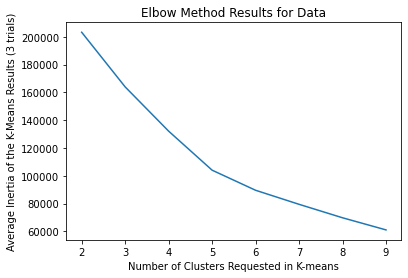

In [46]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [47]:
main_df = pd.concat([scaledX, solidFoodLabelDF], axis = 1)

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=1001).fit(scaledX)
main_df['K_means5'] = kmeans.labels_

In [49]:
main_df.head()

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
0    -0.185277      -0.692440    -0.069507           -0.583216 -0.380672   
1    -0.975316      -0.423147    -0.083708           -0.490870 -0.607275   
2     0.559579      -1.134186    -0.130885           -0.797974 -1.000787   
3     0.065160      -0.616826    -0.111933           -0.411410 -0.595104   
4     0.065160      -0.616826    -0.111942           -0.411410 -0.595104   

   carbohydrates_100g  sugars_100g     main_category Nutri-score  K_means5  
0            0.479272     0.534516  en:sugary-snacks           C         0  
1           -0.681837    -0.690661          en:meals           B         0  
2            2.534931     4.038525  en:sugary-snacks           D         4  
3            1.062838     1.520338       en:desserts           C         4  
4            1.062838     1.520338  en:sugary-snacks           C         4

### see what each group consist of 

In [50]:
main_df.loc[main_df['K_means5'] == 0, ]['Nutri-score'].value_counts()

C    5468
B    4900
D    3502
A    2785
E     105
Name: Nutri-score, dtype: int64

In [51]:
main_df.loc[main_df['K_means5'] == 1, ]['Nutri-score'].value_counts()

E    1132
D    1037
C      80
A       9
B       6
Name: Nutri-score, dtype: int64

In [52]:
main_df.loc[main_df['K_means5'] == 2, ]['Nutri-score'].value_counts()

D    1
E    0
C    0
B    0
A    0
Name: Nutri-score, dtype: int64

In [53]:
main_df.loc[main_df['K_means5'] == 2, ]

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
41282     1.345745      -0.099465   178.467682             0.65164  0.969672   

       carbohydrates_100g  sugars_100g main_category Nutri-score  K_means5  
41282            0.964949    -0.624974  en:groceries           D         2

In [55]:
main_df.loc[main_df['K_means5'] == 3, ]['Nutri-score'].value_counts()

D    4383
C    1862
E    1597
B     782
A     476
Name: Nutri-score, dtype: int64

In [56]:
main_df.loc[main_df['K_means5'] == 4, ]['Nutri-score'].value_counts()

E    6502
D    5486
C    1201
B     169
A      88
Name: Nutri-score, dtype: int64

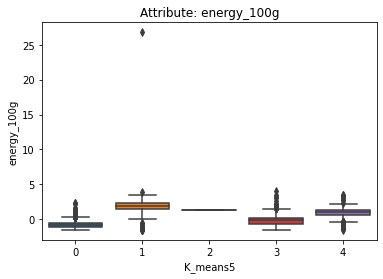

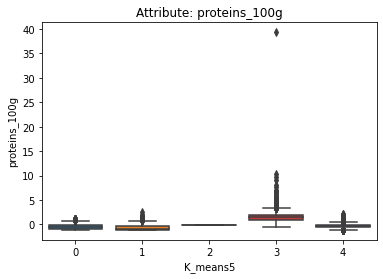

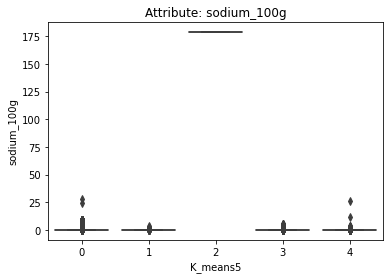

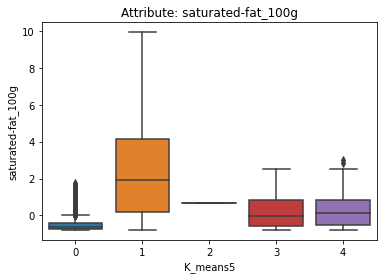

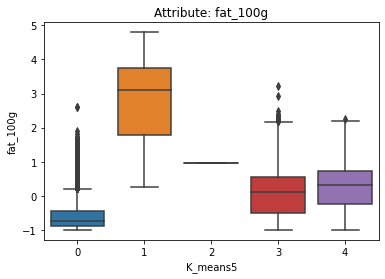

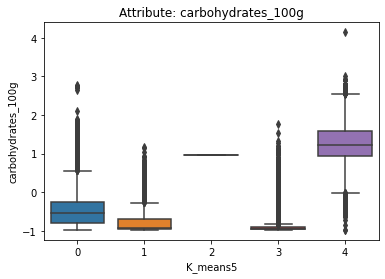

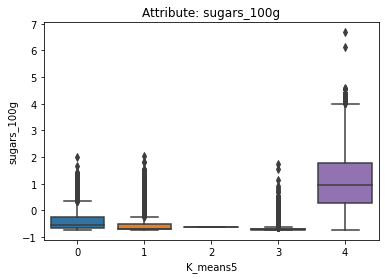

In [144]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means5', y=col, data=main_df)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### Drop that row with exceptional high sodium

In [96]:
data.shape

(41571, 7)

In [58]:
main_df = main_df.drop(index=41282, )

In [61]:
main_df.head()

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
0    -0.185277      -0.692440    -0.069507           -0.583216 -0.380672   
1    -0.975316      -0.423147    -0.083708           -0.490870 -0.607275   
2     0.559579      -1.134186    -0.130885           -0.797974 -1.000787   
3     0.065160      -0.616826    -0.111933           -0.411410 -0.595104   
4     0.065160      -0.616826    -0.111942           -0.411410 -0.595104   

   carbohydrates_100g  sugars_100g     main_category Nutri-score  K_means5  
0            0.479272     0.534516  en:sugary-snacks           C         0  
1           -0.681837    -0.690661          en:meals           B         0  
2            2.534931     4.038525  en:sugary-snacks           D         4  
3            1.062838     1.520338       en:desserts           C         4  
4            1.062838     1.520338  en:sugary-snacks           C         4

In [76]:
scaledX = main_df.iloc[:, 0:7]
solidFoodLabelDF = main_df.iloc[:, [7,8]]

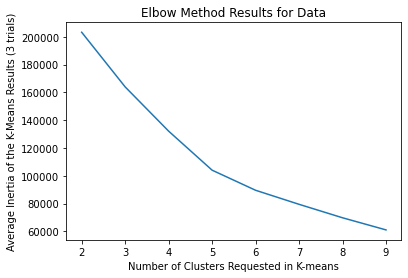

In [70]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [77]:
main_df2 = pd.concat([scaleX, solidFoodLabelDF], axis = 1)

In [80]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=1001).fit(scaledX)
main_df2['K_means5'] = kmeans.labels_

In [81]:
main_df2.head()

energy_100g  proteins_100g  sodium_100g  saturated-fat_100g  fat_100g  \
0    -0.185277      -0.692440    -0.069507           -0.583216 -0.380672   
1    -0.975316      -0.423147    -0.083708           -0.490870 -0.607275   
2     0.559579      -1.134186    -0.130885           -0.797974 -1.000787   
3     0.065160      -0.616826    -0.111933           -0.411410 -0.595104   
4     0.065160      -0.616826    -0.111942           -0.411410 -0.595104   

   carbohydrates_100g  sugars_100g     main_category Nutri-score  K_means5  
0            0.479272     0.534516  en:sugary-snacks           C         1  
1           -0.681837    -0.690661          en:meals           B         1  
2            2.534931     4.038525  en:sugary-snacks           D         4  
3            1.062838     1.520338       en:desserts           C         4  
4            1.062838     1.520338  en:sugary-snacks           C         4

In [82]:
main_df2.loc[main_df2['K_means5'] == 0, ]['Nutri-score'].value_counts()

E    6356
D    3972
C    1046
B     161
A      91
Name: Nutri-score, dtype: int64

In [83]:
main_df2.loc[main_df2['K_means5'] == 1, ]['Nutri-score'].value_counts()

C    5476
B    4906
D    3447
A    2787
E      80
Name: Nutri-score, dtype: int64

In [84]:
main_df2.loc[main_df2['K_means5'] == 2, ]['Nutri-score'].value_counts()

D    4401
C    1857
E    1596
B     779
A     475
Name: Nutri-score, dtype: int64

In [85]:
main_df2.loc[main_df2['K_means5'] == 3, ]['Nutri-score'].value_counts()

E    907
D    756
C     71
B      6
A      5
Name: Nutri-score, dtype: int64

In [86]:
main_df2.loc[main_df2['K_means5'] == 4, ]['Nutri-score'].value_counts()

D    1832
E     397
C     161
B       5
A       0
Name: Nutri-score, dtype: int64

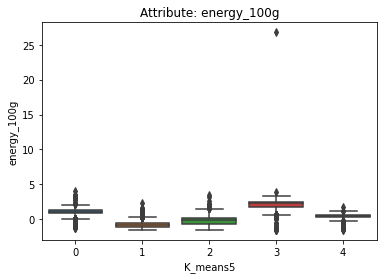

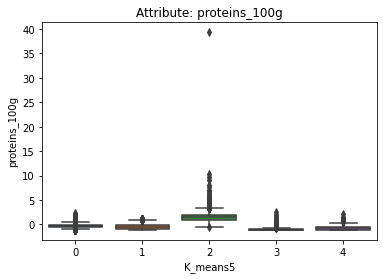

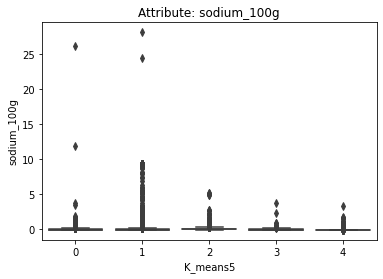

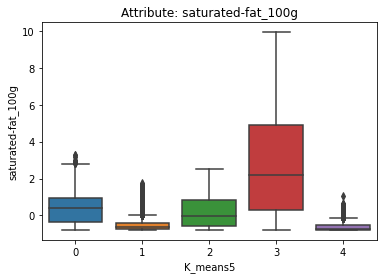

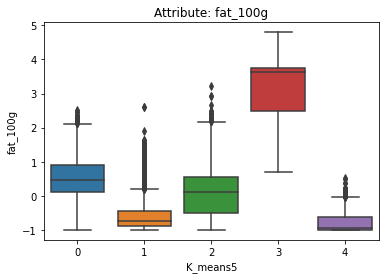

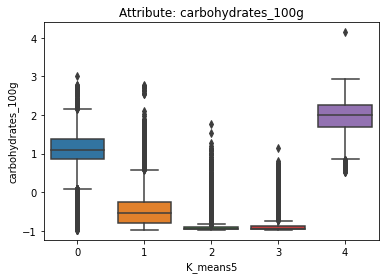

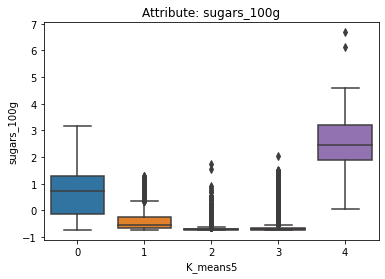

In [89]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means5', y=col, data=main_df2)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

## Try RobustScaler()

In [97]:
solidFoodClusterDF = solidFoodDF.iloc[:, 1:8]
solidFoodLabelDF = solidFoodDF.iloc[:, [0,8]]

In [108]:
solidFoodLabelDF = solidFoodLabelDF.reset_index()

In [101]:
from sklearn.preprocessing import RobustScaler
trans = RobustScaler(quantile_range=(0.05, 0.95))

robustScaledX = trans.fit_transform(solidFoodClusterDF)
robustScaledX = pd.DataFrame(robustScaledX, columns= solidFoodClusterDF.columns)

In [109]:
main_df3 = pd.concat([robustScaledX, solidFoodLabelDF], axis = 1)

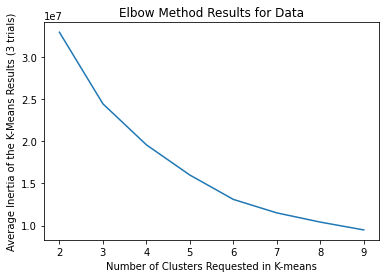

In [111]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(robustScaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [113]:
kmeans = KMeans(n_clusters = 4, random_state=1001).fit(robustScaledX)
main_df3['K_means4'] = kmeans.labels_

In [114]:
main_df3.loc[main_df3['K_means4'] == 0, ]['Nutri-score'].value_counts()

D    3066
E    1900
C     169
A      35
B      14
Name: Nutri-score, dtype: int64

In [115]:
main_df3.loc[main_df3['K_means4'] == 1, ]['Nutri-score'].value_counts()

E    6265
D    4061
C    1228
B     351
A     129
Name: Nutri-score, dtype: int64

In [116]:
main_df3.loc[main_df3['K_means4'] == 2, ]['Nutri-score'].value_counts()

C    7125
D    5596
B    5492
A    3194
E     754
Name: Nutri-score, dtype: int64

In [117]:
main_df3.loc[main_df3['K_means4'] == 3, ]['Nutri-score'].value_counts()

D    1686
E     417
C      89
B       0
A       0
Name: Nutri-score, dtype: int64

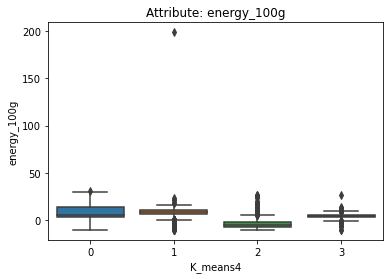

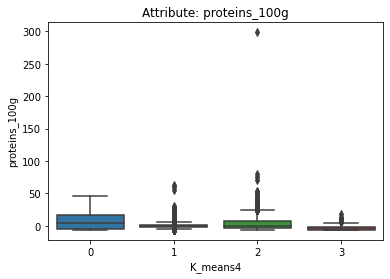

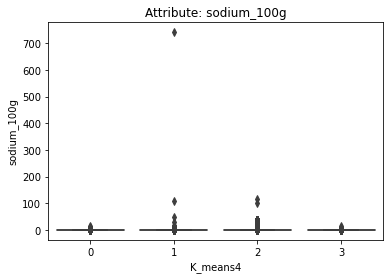

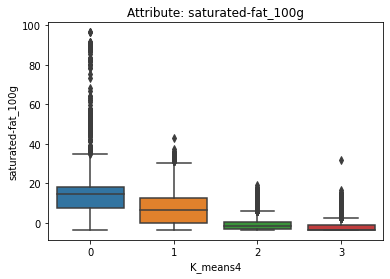

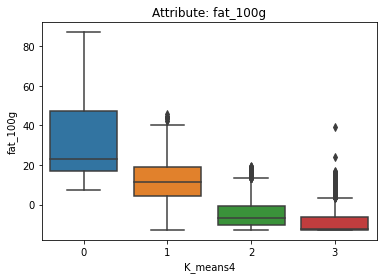

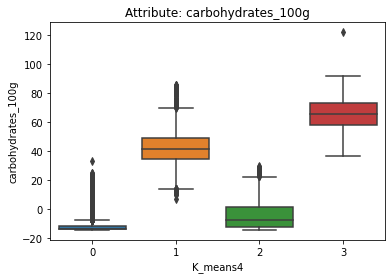

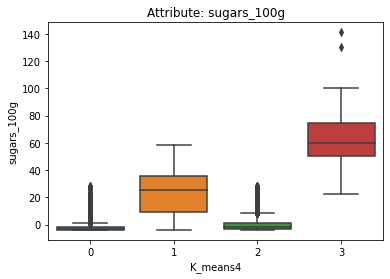

In [118]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means4', y=col, data=main_df3)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### hierarchical4

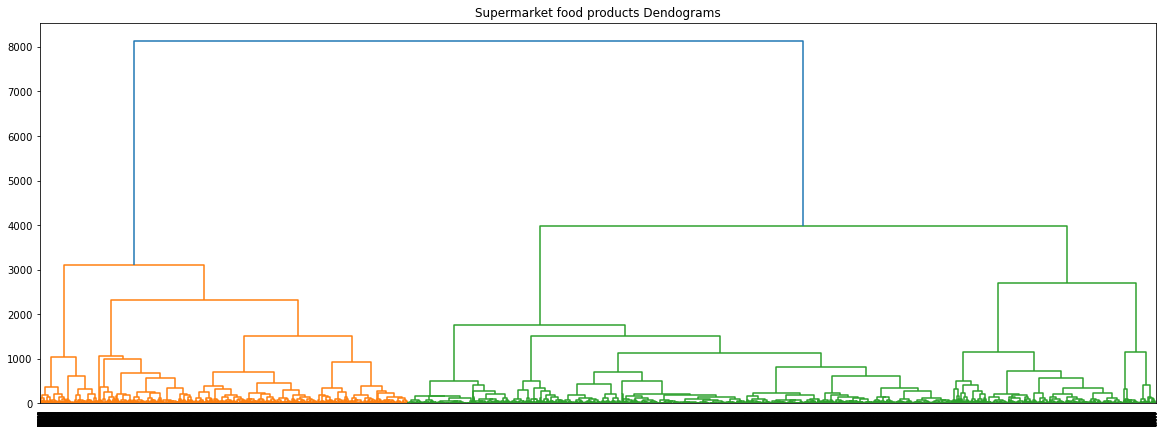

In [119]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("Supermarket food products Dendograms")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(robustScaledX, method='ward'))

In [120]:
agc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

main_df3['hierarchical4'] = agc.fit_predict(robustScaledX)


In [121]:
main_df3.loc[main_df3['hierarchical4'] == 0, ]['Nutri-score'].value_counts ()

D    4482
E    2368
C     579
B      75
A      53
Name: Nutri-score, dtype: int64

In [122]:
main_df3.loc[main_df3['hierarchical4'] == 1, ]['Nutri-score'].value_counts ()

E    6148
D    3715
C    1153
B     352
A     123
Name: Nutri-score, dtype: int64

In [123]:
main_df3.loc[main_df3['hierarchical4'] == 2, ]['Nutri-score'].value_counts ()

C    6759
B    5430
D    4489
A    3182
E     462
Name: Nutri-score, dtype: int64

In [124]:
main_df3.loc[main_df3['hierarchical4'] == 3, ]['Nutri-score'].value_counts ()

D    1723
E     358
C     120
B       0
A       0
Name: Nutri-score, dtype: int64

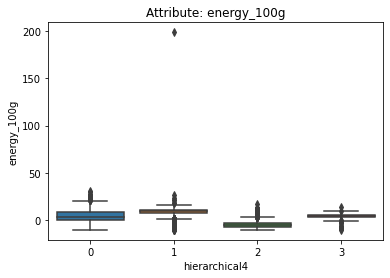

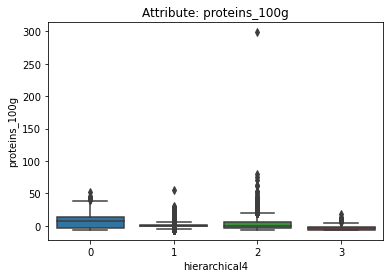

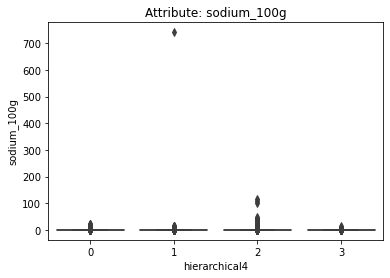

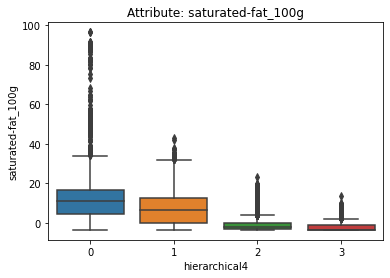

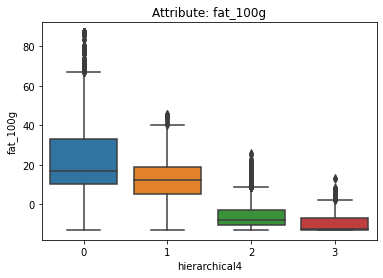

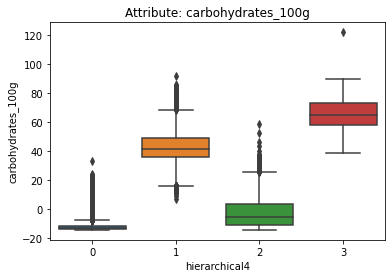

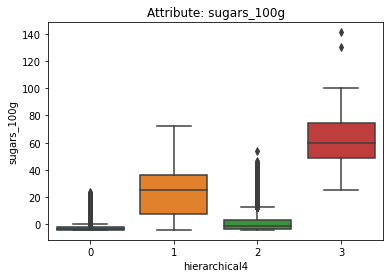

In [125]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='hierarchical4', y=col, data=main_df3)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

In [126]:
sum(main_df3['hierarchical4'] == main_df3['K_means4'] )

38097

In [127]:
len(main_df3['hierarchical4'])

41571